In [1]:
import os
import time
import sys
import scipy
import glob
import re
import cv2

import importlib
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import auxiliary as aux
import plotting as putil

import h5py

In [2]:
util.set_sns_style(style='dark')
%matplotlib notebook

In [3]:
#rootdir = util.get_rootdir()
#rootdir = 'smb://minerva.rockefeller.edu/Julie'
rootdir = '/Volumes/Julie'
experiment = 'P1_activation'
# 
srcdir = os.path.join(rootdir, 'courtship-tethered/behavior', experiment)
logdir = os.path.join(srcdir, 'logfiles')
vidsrc = os.path.join(srcdir, 'videos')

figdir = os.path.join(srcdir, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print("Saving figures to: {}".format(figdir))

Saving figures to: /Volumes/Julie/courtship-tethered/behavior/P1_activation/figures


In [4]:
logfiles = glob.glob(os.path.join(logdir, '*.log'))
len(logfiles)

122

## plotting

In [6]:
pl.rcParams['svg.fonttype'] = 'none'
%matplotlib notebook

plot_style = 'dark'
util.set_sns_style(style=plot_style)
bg_color = 'k' if plot_style=='white' else 'w' 
boutdir_palette = {'inodor': bg_color, 'inbound': 'c', 'outbound': 'm'}
plot_st = '_yt' if plot_style == 'white' else ''
instrip_palette = {True: 'r', False: 'cornflowerblue'}
led_palette = {True: 'r', False: bg_color}

## select fly

In [ ]:
# Canton S ----------------------------
# 20230502-151852_P1_activation_fly2-cantons-5doM-sh_006

# P1 activation -------------------------
# 20230503-115904_P1_activation_fly1-P1-ChR-2do-sh_000 
# 20230503-124415_P1_activation_fly1-P1-ChR-2doM-sh_004
# 20230501-171817_P1_activation_fly4-P1-ChR-3doM-sh_002 maybe
# 20230203-114749_P1_activation_fly1-P1_002

In [45]:
date = '20230502'
fly_num = 2
fly_id = 'fly{}'.format(fly_num)
#re.compile(r'\broses\b| \bmarigolds\b | \borchids\b', flags=re.I | re.X)
r = re.compile(r'{}[^.]*{}'.format(date, fly_id), flags=re.I | re.X)
curr_fns = [f for f in logfiles if r.findall(f)]
curr_fns

['/Volumes/Julie/courtship-tethered/behavior/P1_activation/logfiles/20230502-164550_P1_activation_fly2-cantons-5doM-sh_004.log',
 '/Volumes/Julie/courtship-tethered/behavior/P1_activation/logfiles/20230502-151852_P1_activation_fly2-cantons-5doM-sh_006.log',
 '/Volumes/Julie/courtship-tethered/behavior/P1_activation/logfiles/20230502-131406_P1_activation_fly2-cantons-5doM-sh_001.log',
 '/Volumes/Julie/courtship-tethered/behavior/P1_activation/logfiles/20230502-124513_P1_activation_fly2-cantons-5doM-sh_000.log',
 '/Volumes/Julie/courtship-tethered/behavior/P1_activation/logfiles/20230502-153701_P1_activation_fly2-cantons-5doM-sh_notap_000.log']

In [47]:
xvar = 'ft_posx'
yvar = 'ft_posy'
d_list = []j 
for fn in curr_fns: 
    #fpath = os.path.join(logdir, '{}.log'.format(fn))
    curr_cond = 'notaps' if re.findall('notap', os.path.split(fn)[-1]) else 'taps'
    #print(curr_cond)
    df_ = butil.load_dataframe(fn, is_odor=False, remove_invalid=False)
    # process some stuff
    df_['condition'] = curr_cond
    df_['fly_id'] = fly_id
    df_ = aux.process_df_blocks(df_)
    df_.loc[df_['speed']>100] = None
    #fly_id = os.path.splitext(os.path.split(fpath)[-1])[0]
    d_list.append(df_)
df0 = pd.concat(d_list, axis=0)

/Users/julianarhee/Repositories/plume-tracking/auxiliary.py:118: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_.loc[start_ix:end_ix, 'blocknum'] = bi
/Users/julianarhee/Repositories/plume-tracking/auxiliary.py:118: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_.loc[start_ix:end_ix, 'blocknum'] = bi
/Users/julianarhee/Repositories/plume-tracking/auxiliary.py:118: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df

In [48]:
df0['led_on'].unique()

array([False, nan, True], dtype=object)

In [49]:
df0['filename'].unique()

array(['20230502-164550_P1_activation_fly2-cantons-5doM-sh_004', None,
       '20230502-151852_P1_activation_fly2-cantons-5doM-sh_006',
       '20230502-131406_P1_activation_fly2-cantons-5doM-sh_001',
       '20230502-124513_P1_activation_fly2-cantons-5doM-sh_000',
       '20230502-153701_P1_activation_fly2-cantons-5doM-sh_notap_000'],
      dtype=object)

<IPython.core.display.Javascript object>


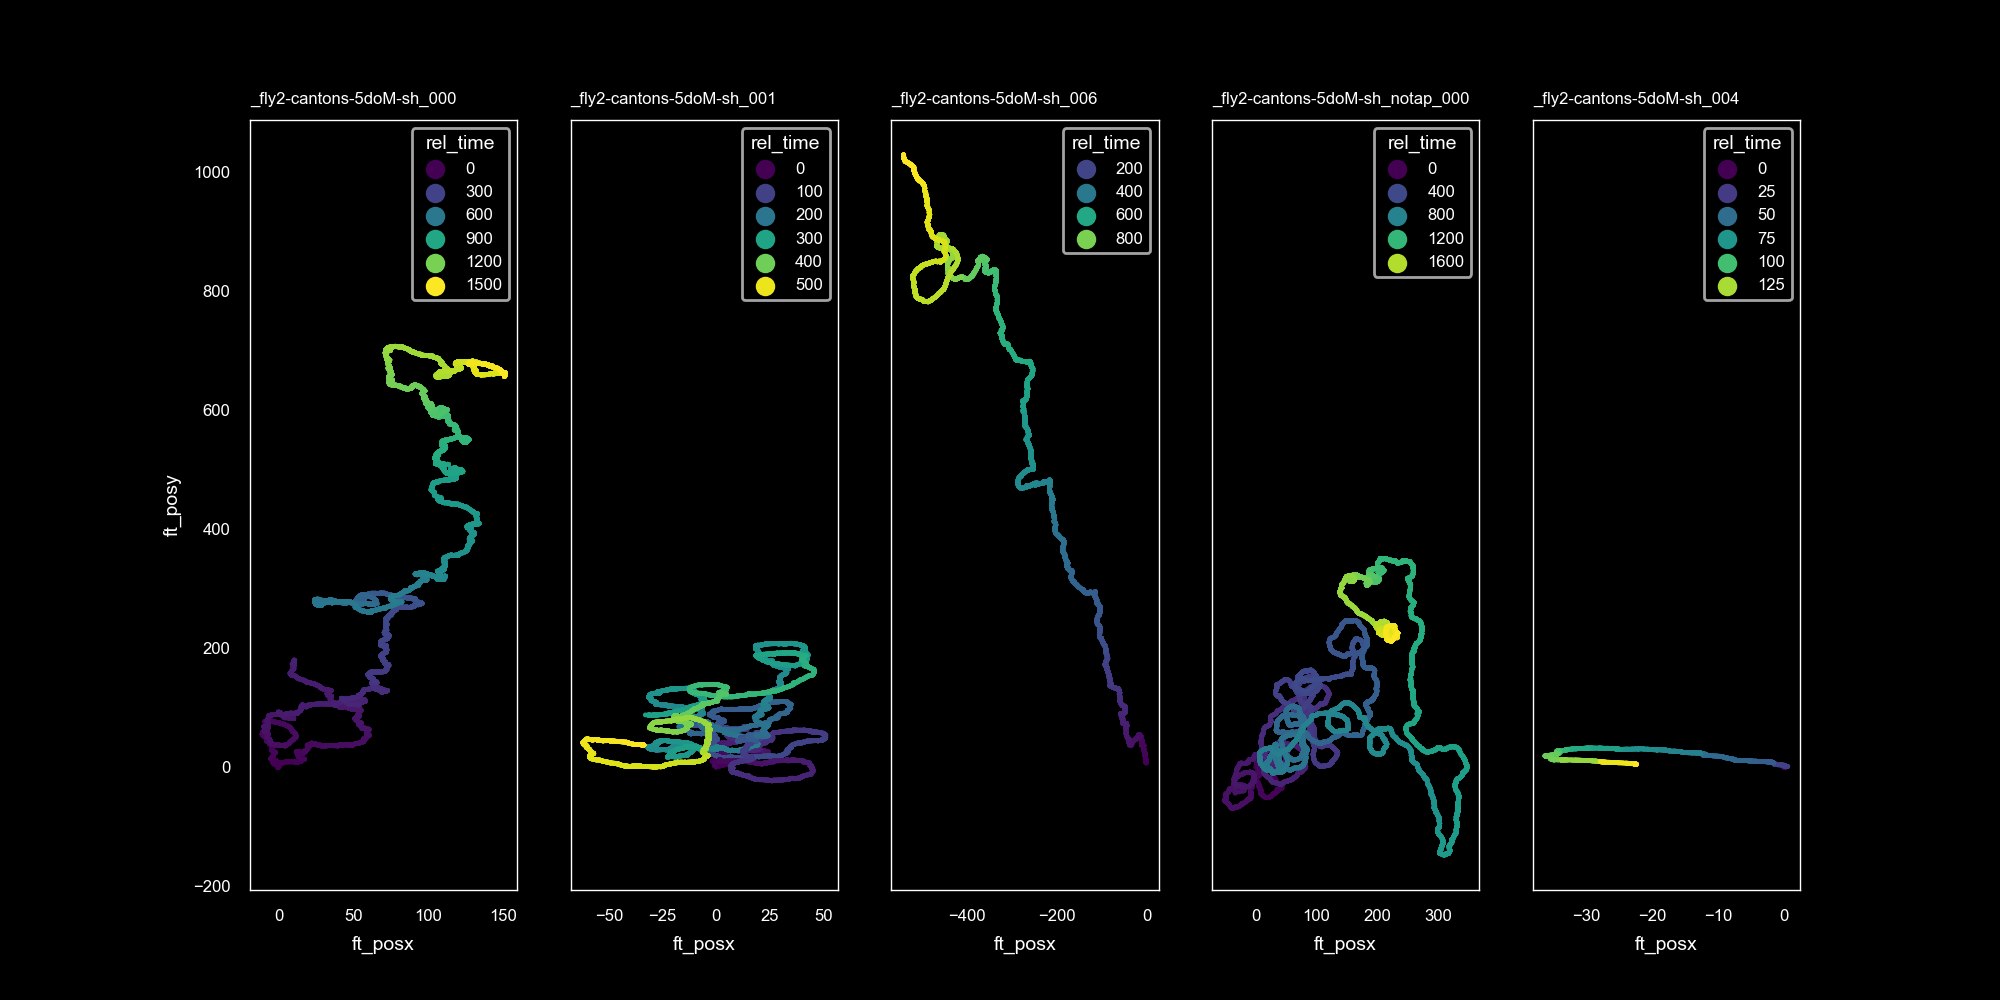

In [52]:
n_files = df0['filename'].nunique()
fig, axn = pl.subplots(1, n_files,  figsize=(10,5), sharey=True)
ai = 0
for fn, df_ in df0.groupby('filename'):
    ax=axn[ai]
    ax.set_title(fn.split('P1_activation')[-1], loc='left', fontsize=6)
    
#     sns.scatterplot(data=df_, x=xvar, y=yvar, hue='led_on', palette=led_palette, ax=ax,
#                    edgecolor='none', s=3)
    sns.scatterplot(data=df_, x=xvar, y=yvar, hue='rel_time', palette='viridis', ax=ax,
                   edgecolor='none', s=3)
    ai += 1

In [61]:
# fn = '20230503-115904_P1_activation_fly1-P1-ChR-2do-sh_000'
# fn = '20230503-124415_P1_activation_fly1-P1-ChR-2doM-sh_004'
# fn = '20230502-124513_P1_activation_fly2-cantons-5doM-sh_000'
#fn = '20230501-171817_P1_activation_fly4-P1-ChR-3doM-sh_002'

# fn = '20230502-131406_P1_activation_fly2-cantons-5doM-sh_001'
fn = '20230502-124513_P1_activation_fly2-cantons-5doM-sh_000'
df_ = df0[df0['filename']==fn].copy()
df_['blocknum'].unique()

array([0., 1., 2.])

<IPython.core.display.Javascript object>


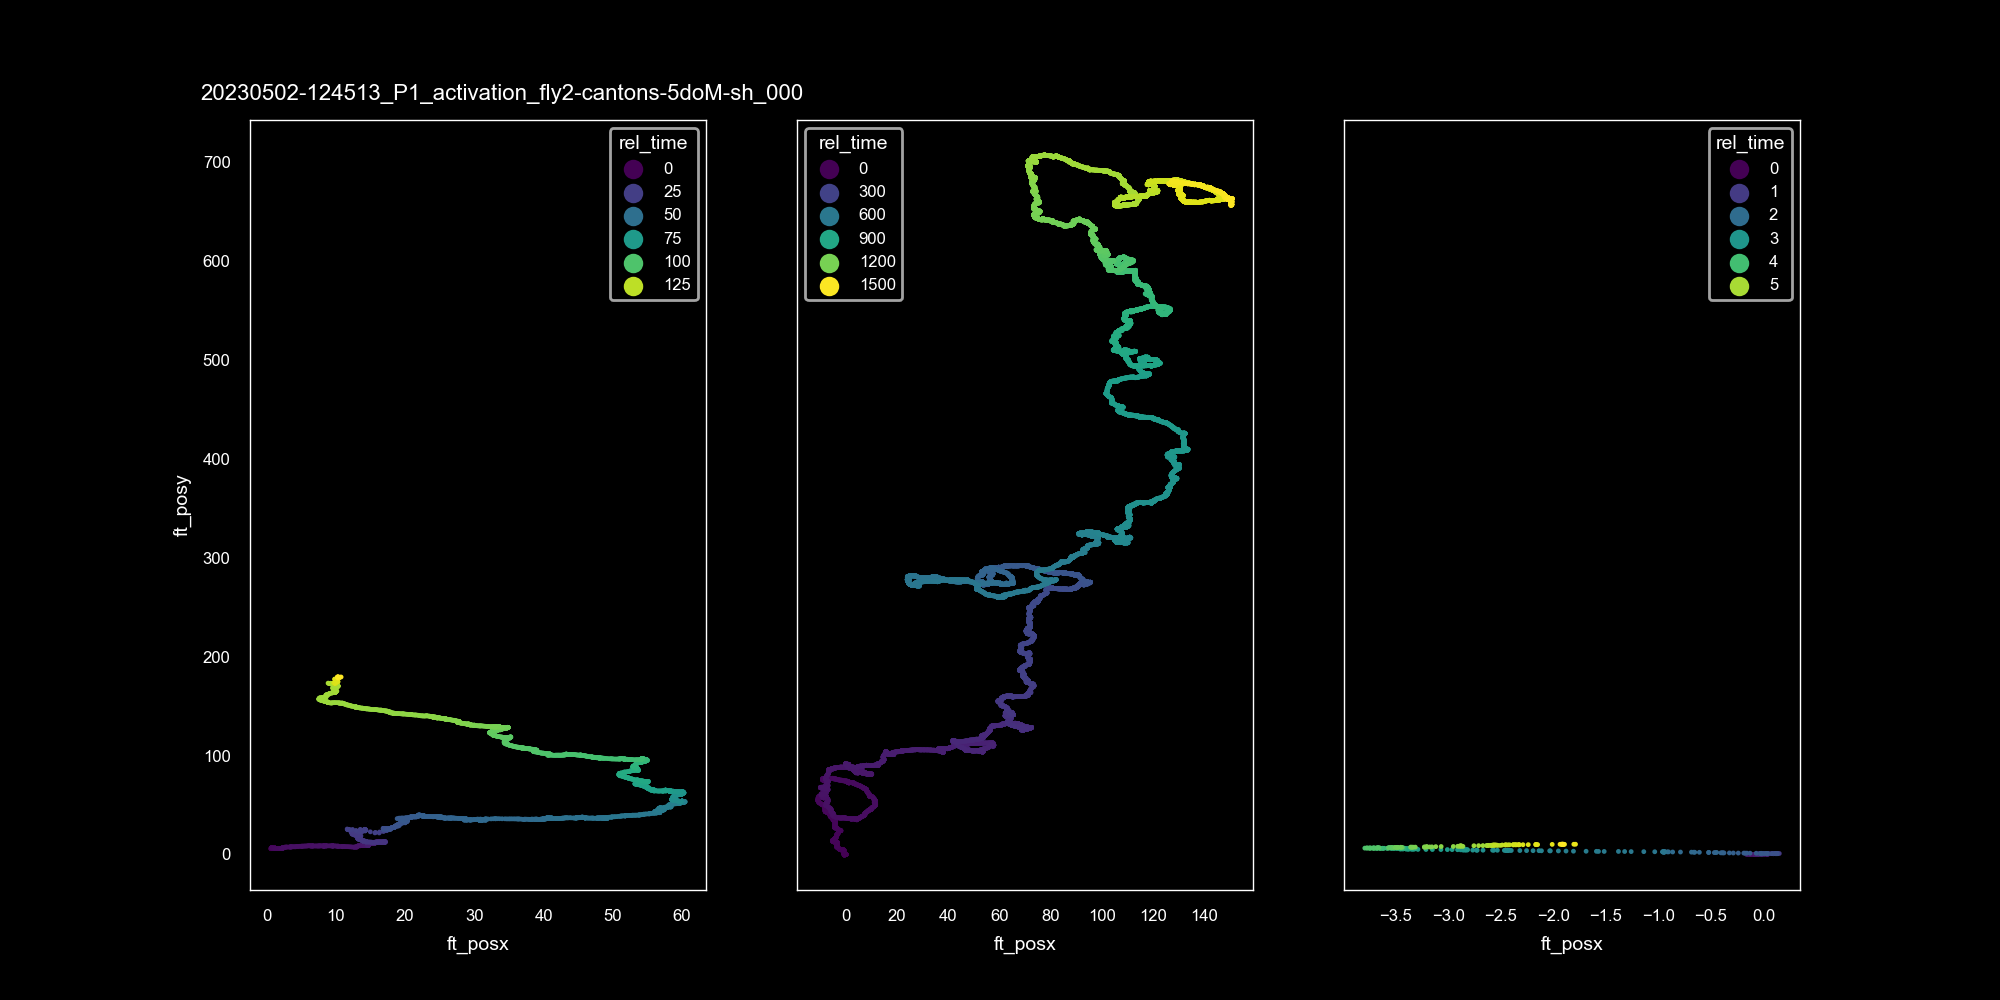

Text(0.1, 0.9, '20230502-124513_P1_activation_fly2-cantons-5doM-sh_000')

In [62]:
#fn = '20230503-115904_P1_activation_fly1-P1-ChR-2do-sh_000'
#df_ = df0[df0['filename']==fn].copy()
n_blocks = df_['blocknum'].nunique()
fig, axn = pl.subplots(1, n_blocks,  figsize=(10,5), sharey=True)
ai = 0
for bnum, currdf in df_.groupby('blocknum'):
    ax=axn[ai] if n_blocks>1 else axn
    sns.scatterplot(data=currdf, x=xvar, y=yvar, hue='rel_time', palette='viridis', ax=ax,
                   edgecolor='none', s=3)
    ai += 1
fig.text(0.1, 0.9, fn, fontsize=8)

## find resets

#### test 1 example file for 1 fly (containing multiple blocks)

In [9]:
fname = '20230502-151852_P1_activation_fly2-cantons-5doM-sh_006'
df_ = df0[df0['filename']==fname].copy()

<IPython.core.display.Javascript object>


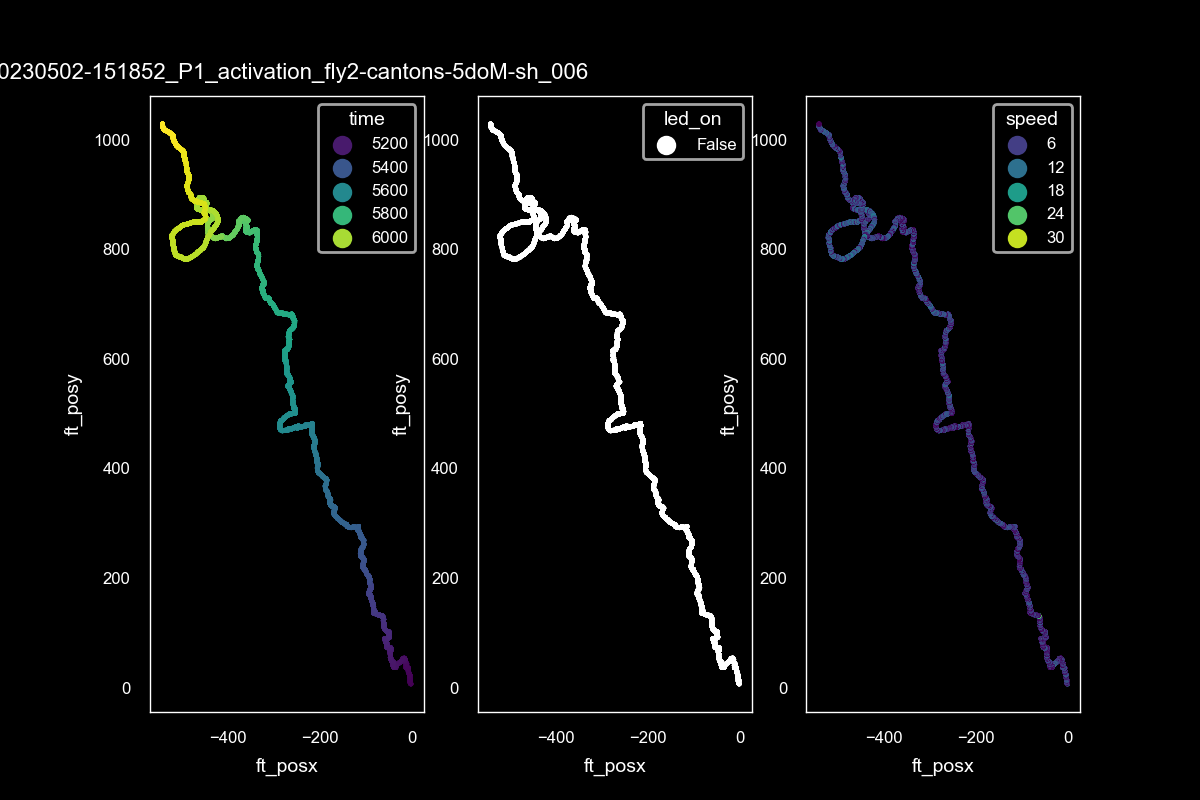

In [10]:
for bnum, currd in df_.groupby('blocknum'):
    fig, axn = pl.subplots(1,3)
    ax=axn[0]
    sns.scatterplot(data=currd, x=xvar, y=yvar, hue='time', palette='viridis', ax=ax,
                   edgecolor='none', s=3)
    fname = currd['filename'].iloc[0]
    ax.set_title(fname, fontsize=8)
    ax=axn[1]
    sns.scatterplot(data=currd, x=xvar, y=yvar, hue='led_on', palette=led_palette, ax=ax,
                   edgecolor='none', s=3)
    ax=axn[2]
    sns.scatterplot(data=currd, x=xvar, y=yvar, hue='speed', palette='viridis', ax=ax,
                   edgecolor='none', s=3)
    

In [11]:
df_[['ft_posx', 'ft_posy', 'ft_frame', 'blocknum','speed']]

ft_posx      ft_posy  ft_frame  blocknum      speed
1       -1.315700     6.595569     112.0       0.0  20.758254
2       -1.418235     6.709849     113.0       0.0   8.962518
3       -1.550826     6.788475     114.0       0.0   7.928904
4       -1.682888     6.764907     115.0       0.0   8.634902
5       -1.831623     6.768857     116.0       0.0   7.959387
...           ...          ...       ...       ...        ...
59989 -541.073867  1028.564056   60102.0       0.0   0.200942
59990 -541.095837  1028.568363   60103.0       0.0   0.139721
59991 -541.071557  1028.567973   60104.0       0.0   0.714560
59992 -541.071622  1028.565713   60105.0       0.0   0.108910
59993 -541.072561  1028.564479   60106.0       0.0   0.097583

[59993 rows x 5 columns]

## plot

In [12]:
df0[['filename', 'blocknum']].drop_duplicates().dropna().shape[0]

9

In [91]:
df0['rel_time'].max(),

(1810.5929880142212,)

<IPython.core.display.Javascript object>


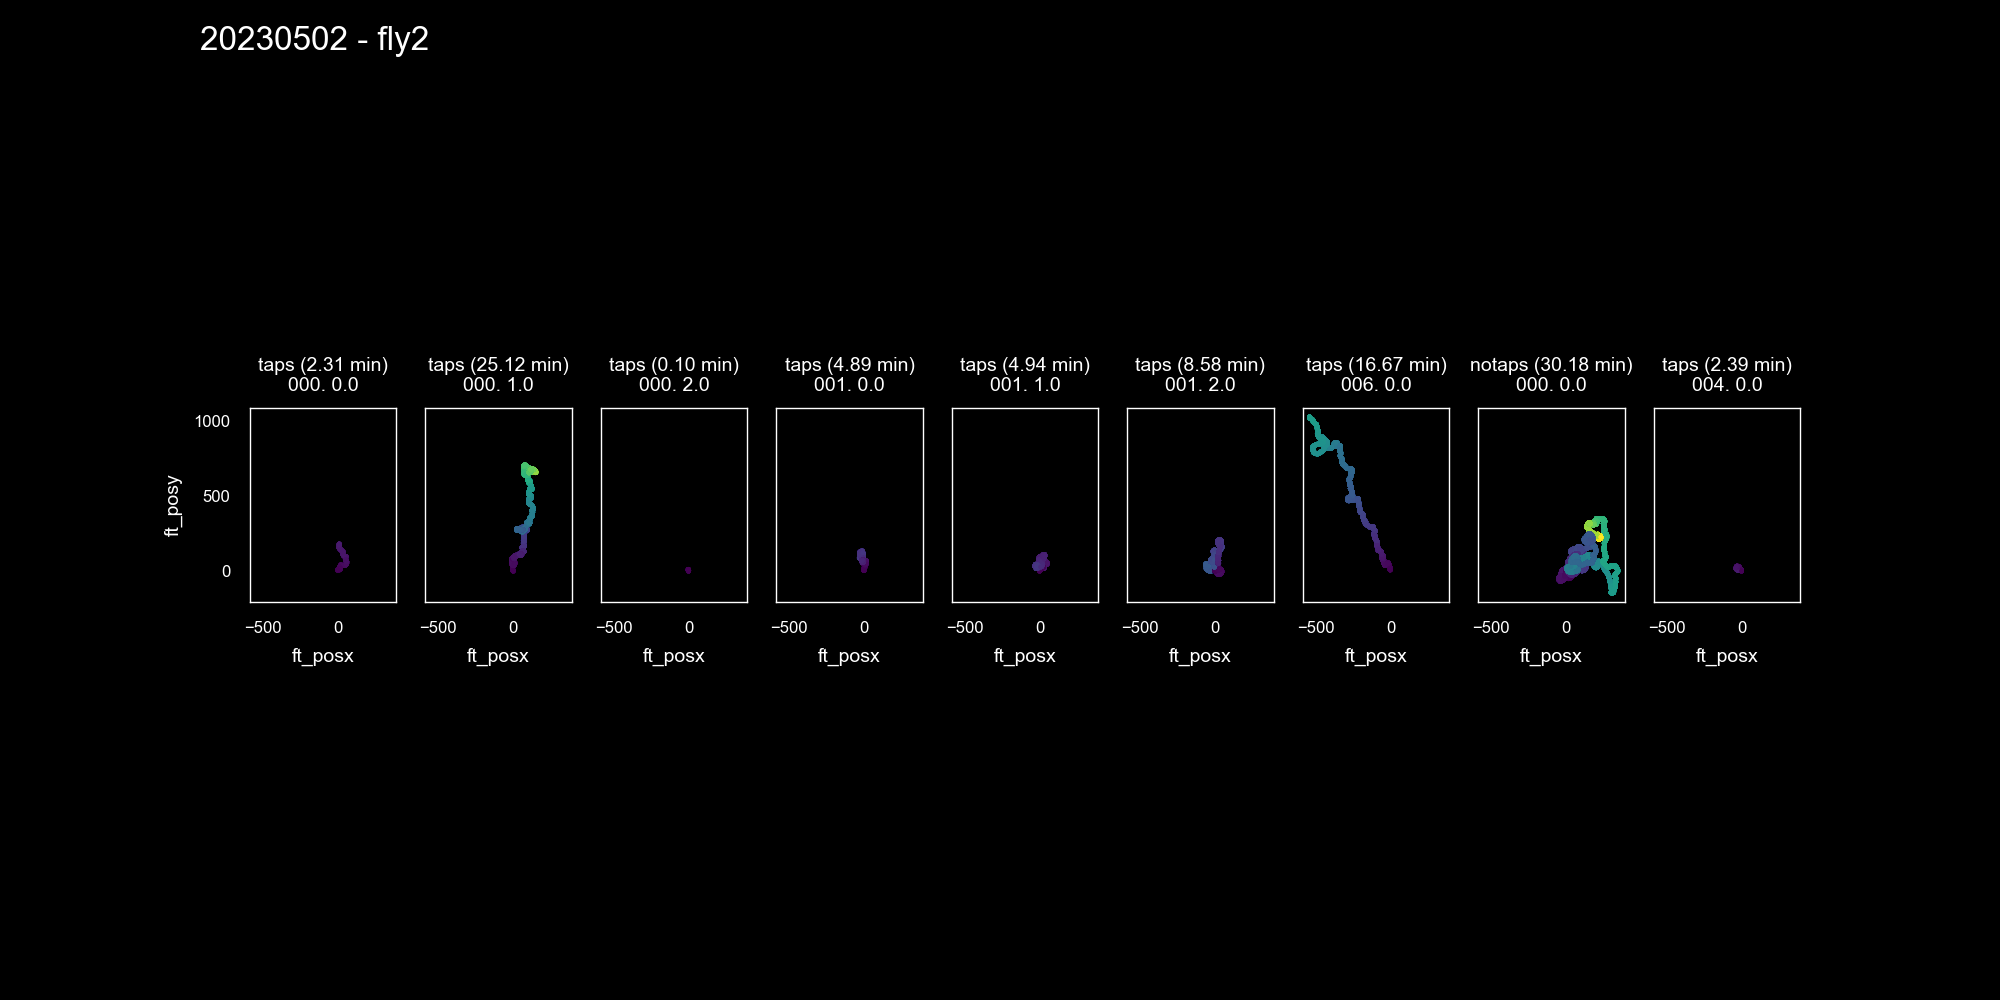

('20230502-124513_P1_activation_fly2-cantons-5doM-sh_000', 0.0)
('20230502-124513_P1_activation_fly2-cantons-5doM-sh_000', 1.0)
('20230502-124513_P1_activation_fly2-cantons-5doM-sh_000', 2.0)
('20230502-131406_P1_activation_fly2-cantons-5doM-sh_001', 0.0)
('20230502-131406_P1_activation_fly2-cantons-5doM-sh_001', 1.0)
('20230502-131406_P1_activation_fly2-cantons-5doM-sh_001', 2.0)
('20230502-151852_P1_activation_fly2-cantons-5doM-sh_006', 0.0)
('20230502-153701_P1_activation_fly2-cantons-5doM-sh_notap_000', 0.0)
('20230502-164550_P1_activation_fly2-cantons-5doM-sh_004', 0.0)


Text(0.1, 0.95, '20230502 - fly2')

In [93]:
curr_trials = df0[['filename', 'blocknum']].drop_duplicates().dropna().shape[0]
fig, axn = pl.subplots(1, curr_trials, figsize=(10, 5), sharex=True, sharey=True)
    
for fi, (fn, df_) in enumerate(df0.sort_values(by='filename').groupby(['filename', 'blocknum'])):
    ax=axn[fi]
    dur_min = df_['rel_time'].max() / 60.
    sns.scatterplot(data=df_, x=xvar, y=yvar, hue='rel_time', palette='viridis', ax=ax,
                   edgecolor='none', s=3 , legend=0, 
                    hue_norm=mpl.colors.Normalize(vmin=0, vmax=1800))
    curr_cond = df_['condition'].unique()[0]
    ax.set_title('{} ({:.2f} min)\n{}. {}'.format(curr_cond, dur_min, fn[0].split('_')[-1], fn[-1]))
    #util.label_figure(fig, '{}'.format(os.path.split(fn)[-1]))
    figname = '{}'.format(fn)
    print(fn)
    ax.set_aspect('equal')
    
fig.text(0.1, 0.95, '{} - {}'.format(date, fly_id), fontsize=12)

## merge blocks

In [104]:
util.set_sns_style(style='dark', min_fontsize=12)

In [105]:
filenames = sorted(df0['filename'].dropna().unique())
filenames

['20230502-124513_P1_activation_fly2-cantons-5doM-sh_000',
 '20230502-131406_P1_activation_fly2-cantons-5doM-sh_001',
 '20230502-151852_P1_activation_fly2-cantons-5doM-sh_006',
 '20230502-153701_P1_activation_fly2-cantons-5doM-sh_notap_000',
 '20230502-164550_P1_activation_fly2-cantons-5doM-sh_004']

'fly2-cantons-5doM-sh'

In [106]:
#df = df0[df0['filename']==filenames[0]].copy()
df_list = []
for fn, df in df0.groupby('filename'):
    # Get last points of 1st file
    last_x, last_y, last_t = df[df['blocknum']==0][['ft_posx', 'ft_posy', 'rel_time']].iloc[-1]
    for bnum, block_ in df.groupby('blocknum'):
        if bnum==0:
            continue
        print(last_x, last_y, last_t)
        curr_xvs = df[df['blocknum']==bnum]['ft_posx'].values
        curr_yvs = df[df['blocknum']==bnum]['ft_posy'].values
        curr_ts = df[df['blocknum']==bnum]['rel_time'].values

        # add offsets
        df.loc[df['blocknum']==bnum, 'ft_posx'] = curr_xvs + last_x
        df.loc[df['blocknum']==bnum, 'ft_posy'] = curr_yvs + last_y
        df.loc[df['blocknum']==bnum, 'rel_time'] = curr_ts + last_t
        # update last
        last_x, last_y, last_t = df[df['blocknum']==bnum][['ft_posx', 'ft_posy', 'rel_time']].iloc[-1]
    df_list.append(df)

10.7566399487937 179.334759101127 138.6728971004486
161.5482833435127 835.906819096287 1645.746250152588
-33.081272143812 87.269632092303 293.4069118499756
-40.2168690487575 115.3061188534773 590.0339448451996


In [107]:
merged_df = pd.concat(df_list)

<IPython.core.display.Javascript object>


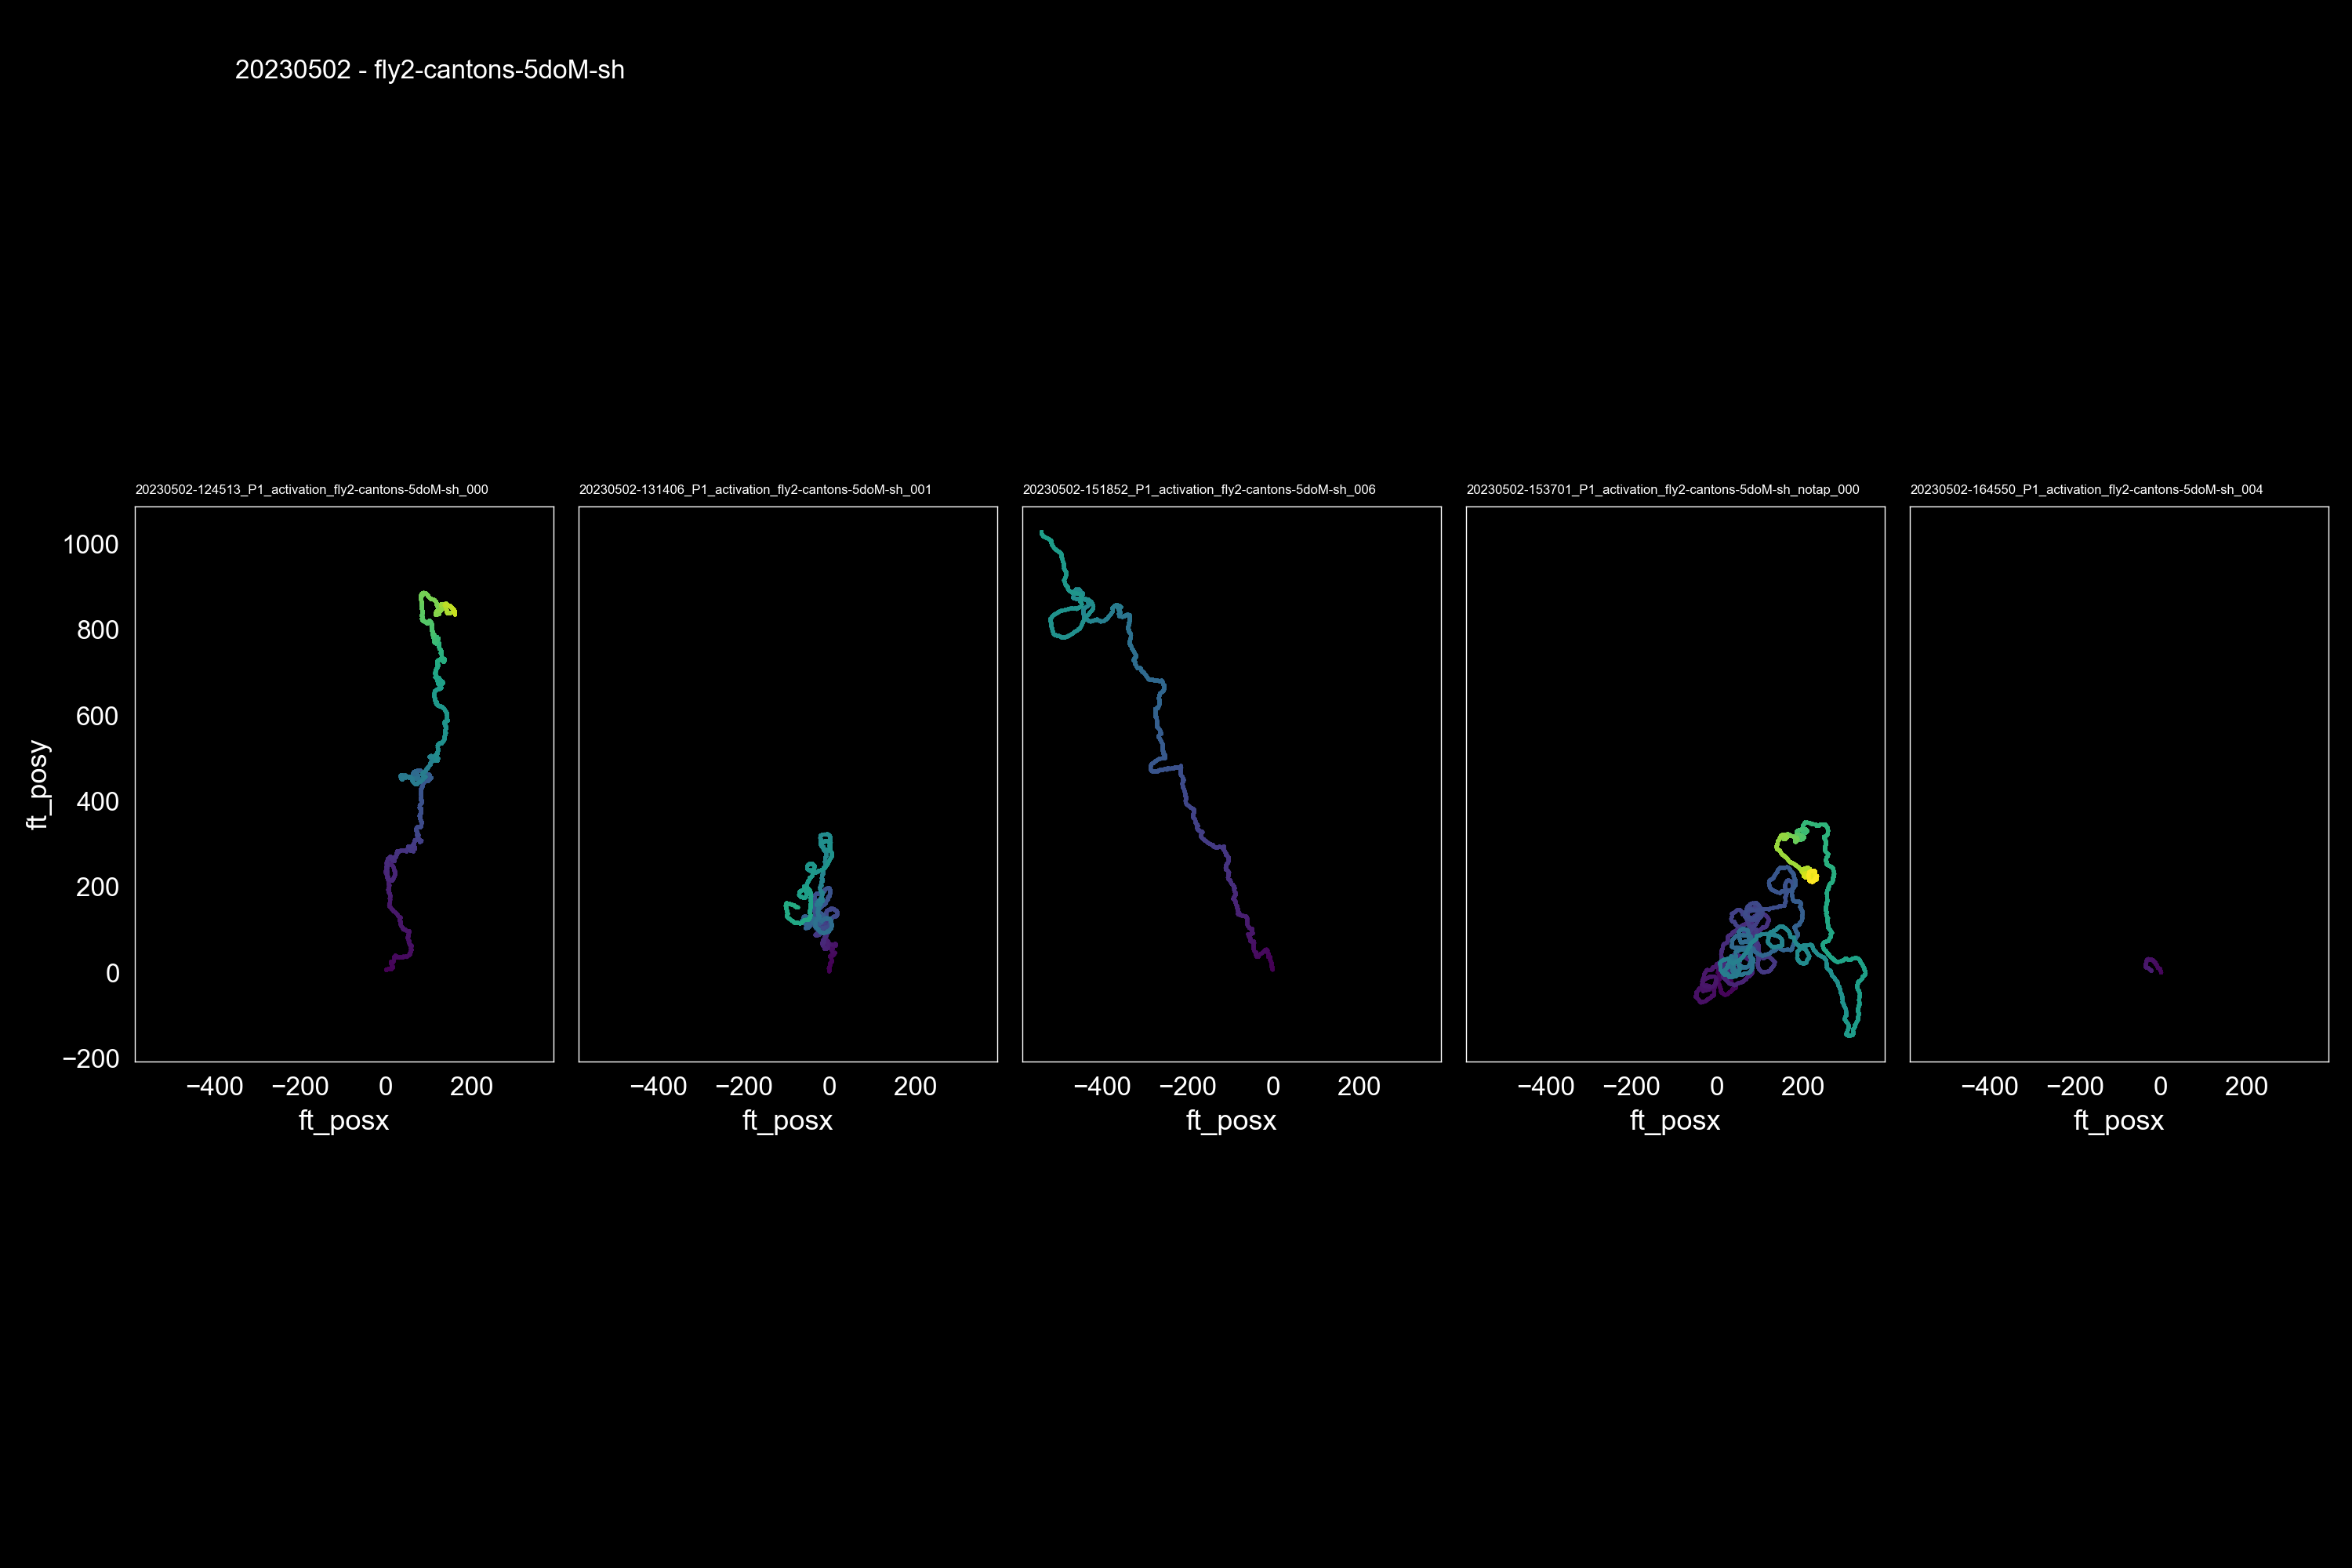

PermissionError: [Errno 13] Permission denied

In [120]:
n_filenames = merged_df['filename'].nunique()

fig, axn  = pl.subplots(1, n_filenames, figsize=(15, 10), sharey=True, sharex=True)
for fi, (fn, df_) in enumerate(merged_df.groupby('filename')):
    ax=axn[fi]
    dur_min = df_['rel_time'].max() / 60.
    sns.scatterplot(data=df_, x=xvar, y=yvar, hue='rel_time', palette='viridis', ax=ax,
                   edgecolor='none', s=3 , legend=0, 
                    hue_norm=mpl.colors.Normalize(vmin=0, vmax=1800))
    ax.set_title(fn, loc='left', fontsize=6)
    ax.set_aspect('equal')

fly_info = '_'.join(filenames[0].split('_')[3:-1])

fig.text(0.1, 0.95, '{} - {}'.format(date, fly_info), fontsize=12)
pl.tight_layout()
pl.savefig(os.path.join(figdir, '{}_{}_merged.png'.format(date, fly_info)), dpi=300)
pl.savefig(os.path.join(figdir, '{}_{}_merged.svg'.format(date, fly_info)), dpi=300)


## side-camera frames

#### start with 1 file

<IPython.core.display.Javascript object>


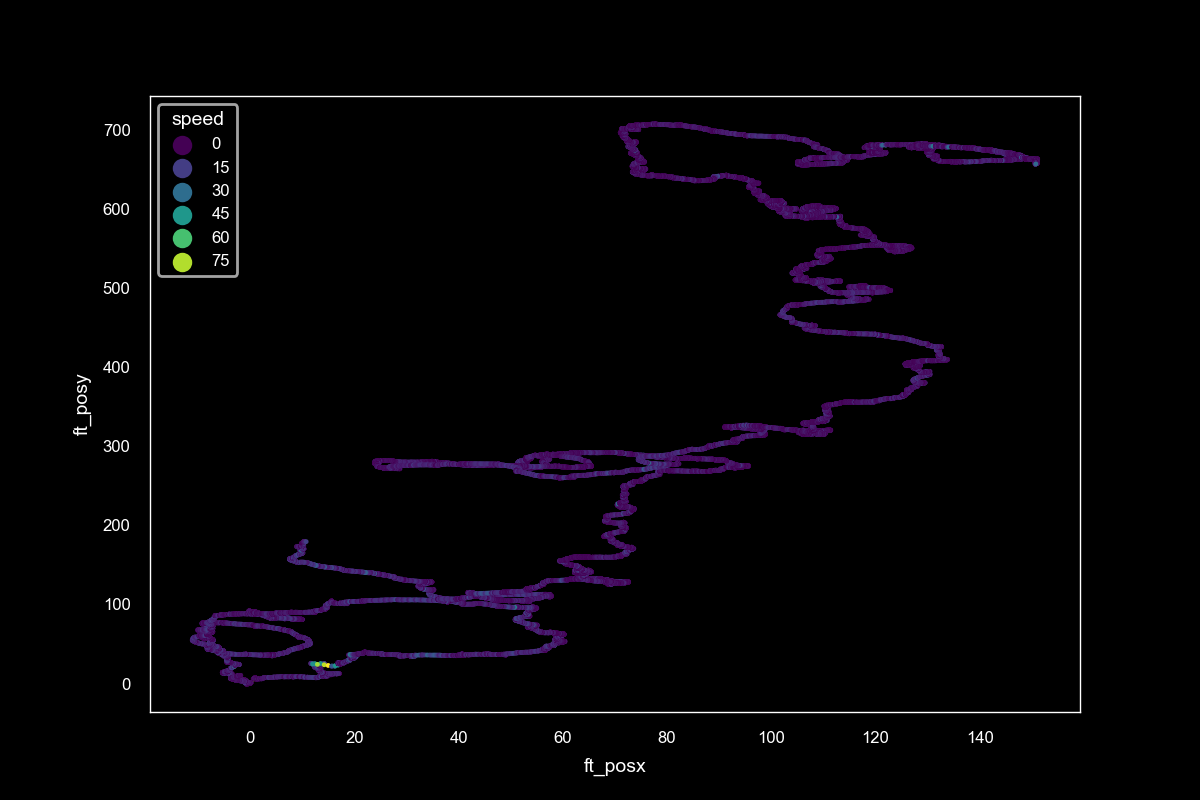

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [14]:
fn = '20230502-124513_P1_activation_fly2-cantons-5doM-sh_000'
bnum = 0 #1 is vv long

df_ = df0[ (df0['filename']==fn)].copy() #& (df0['blocknum']==bnum)].copy()
fig, ax = pl.subplots()
sns.scatterplot(data=df_, x=xvar, y=yvar, hue='speed', palette='viridis', ax=ax,
                   edgecolor='none', s=3)

#### get corresponding video

In [15]:
print(vidsrc)
vid_fname = aux.find_synced_video_name(fn, vidsrc)
vidpath = os.path.join(vidsrc, vid_fname)
vidpath

/Volumes/Julie/courtship-tethered/behavior/P1_activation/videos


'/Volumes/Julie/courtship-tethered/behavior/P1_activation/videos/20230502-124455_fly2-cantons-5doM-sh'

In [19]:
meta_fpath = glob.glob(os.path.join(vidpath, '*.h5'))[0]
print(meta_fpath)
meta = aux.h5_to_df(meta_fpath)
vid_fpath = os.path.join(vidpath, '{}.avi'.format(meta_fpath.split('_metadata')[0]))
print("Video path exists:", os.path.exists(vid_fpath))
meta.head()

/Volumes/Julie/courtship-tethered/behavior/P1_activation/videos/20230502-124455_fly2-cantons-5doM-sh/sideview_20230502124455_00000_metadata.h5
Video path exists: True


cputime  framecount  frameid    serial    sestime  timestamp
0  1.683046e+09           1        1  24516213  18.043213  18.017459
1  1.683046e+09           2        2  24516213  18.073923  18.048293
2  1.683046e+09           3        3  24516213  18.091225  18.064955
3  1.683046e+09           4        4  24516213  18.106852  18.081617
4  1.683046e+09           5        5  24516213  18.123679  18.098279

In [20]:
meta['cputime'].iloc[-1] - meta['cputime'].iloc[0]

1664.799242734909

In [21]:
(df_['time'].iloc[-1] - df_['time'].iloc[0]) 

1664.893387079239

Num VOE frames: 97708, N camera: 99916


<IPython.core.display.Javascript object>


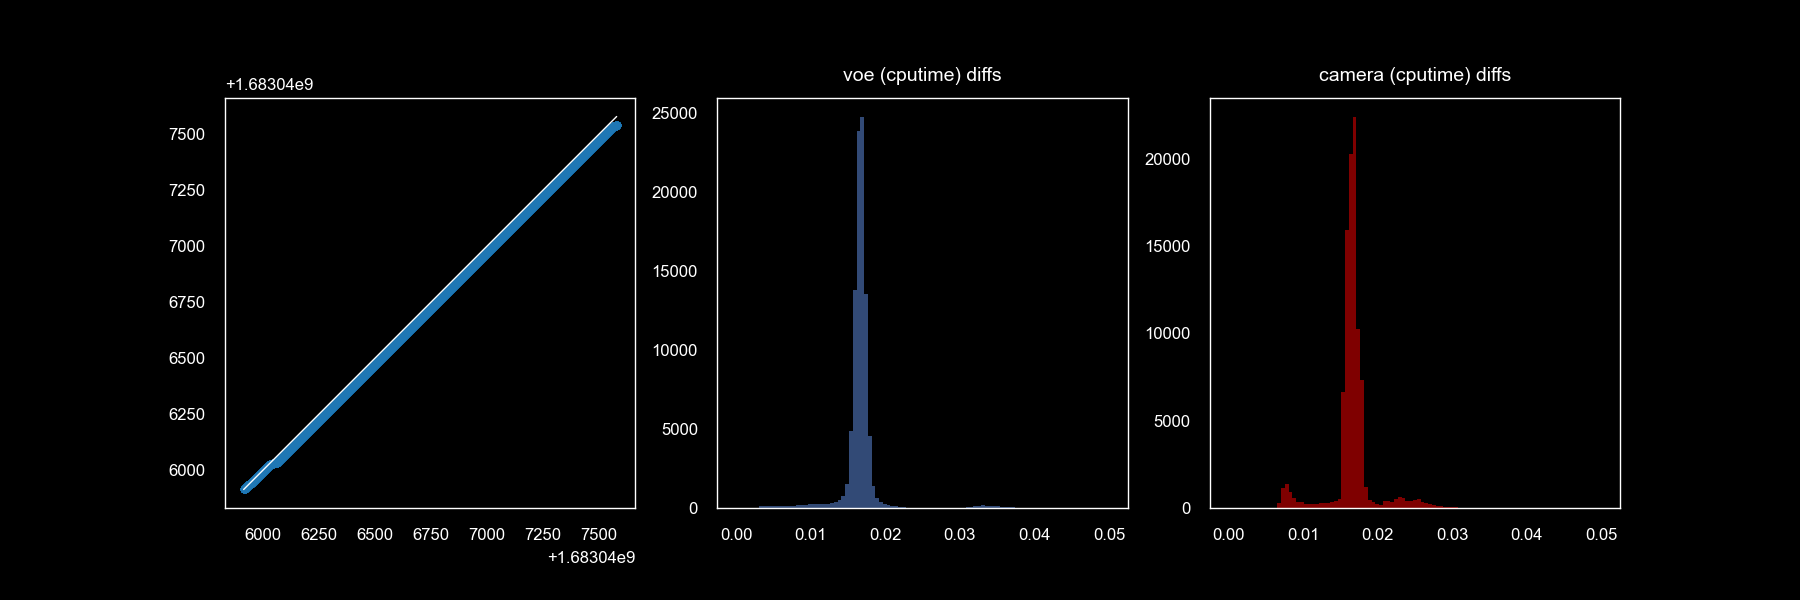

Found 35 frames occuring > 0.05s apart


Text(0.5, 1.0, 'camera (cputime) diffs')

In [22]:
npoints = len(df_['time'])
print('Num VOE frames: {}, N camera: {}'.format(len(df_['time']), len(meta['cputime'])))

fig, axn = pl.subplots(1, 3, figsize=(9,3))
ax=axn[0]
ax.scatter(df_['time'], meta['cputime'].iloc[0:npoints], s=3)
ax.plot([df_['time'].min(), df_['time'].max()], \
        [meta['cputime'].min(), meta['cputime'].max()], 'w', lw=0.5)
ax.set_aspect('equal')

ax=axn[1]
t_thr_upper = 0.05
bins = np.linspace(0, t_thr_upper, 100)
diff_voe = df_['time'].diff()
print("Found {} frames occuring > {}s apart".format(len(diff_voe[diff_voe>0.05]), t_thr_upper))
ax.hist(diff_voe, bins=bins, color='cornflowerblue', lw=0, alpha=0.5)
ax.set_box_aspect(1)
ax.set_title('voe (cputime) diffs')

ax=axn[2]
_ = ax.hist(meta['cputime'].diff(), bins=bins, color='red', lw=0, alpha=0.5)
ax.set_box_aspect(1)
ax.set_title('camera (cputime) diffs')

# interpolate

#### look at 1 block

In [23]:
df_ = df0[ (df0['filename']==fn) & (df0['blocknum']==bnum)].copy()
tmin_voe = df_['time'].min()
tmax_voe = df_['time'].max()

#mt_ = meta[(meta['cputime']>=tmin_voe) & (meta['cputime']<=tmax_voe)].copy()
cam_start_ix = meta.iloc[(meta['cputime']-tmin_voe).abs().argsort()[0]].name
cam_end_ix = meta.iloc[(meta['cputime']-tmax_voe).abs().argsort()[0]].name
mt_ = meta.loc[cam_start_ix:cam_end_ix].copy()

voe_dur = df_['time'].iloc[-1] - df_['time'].iloc[0]
cam_dur = mt_['cputime'].iloc[-1] - mt_['cputime'].iloc[0]
print('Dur:  voe {}, cam {}'.format(voe_dur, cam_dur))

Dur:  voe 138.6728971004486, cam 138.52096223831177


In [24]:
df_.shape, mt_.shape

((6996, 45), (8314, 6))

In [89]:
cam_start_ix

0

In [25]:
import scipy as sp

In [51]:
def circular_interpolation(x: np.ndarray, xp: np.ndarray, fp: np.ndarray, 
                           period: float = 360, discont: float = np.pi) -> np.ndarray:
    """
    From eharbitz:
    https://stackoverflow.com/questions/27295494/bounded-circular-interpolation-in-python
    One dimensional linear interpolation for monotonically increasing sample points where points first are unwrapped,
    secondly interpolated and finally bounded within the specified period.
    
    :param x: The x-coordinates at which to evaluate the interpolated values.
    :param xp: The x-coordinates of the data points, must be increasing.
    :param fp: The y-coordinates of the data points, same length as `xp`.
    :param period: Size of the range over which the input wraps.
    :return: The interpolated values, same shape as `x`.
    """
    
    y = np.mod(np.interp(x, xp, np.unwrap(fp, discont=discont, period=period)), period)
    return y

In [78]:
df_.columns

Index(['index', 'timestamp -- motor_step_command', 'mfc1_stpt', 'mfc2_stpt',
       'mfc3_stpt', 'led1_stpt', 'led2_stpt', 'sig_status', 'ft_posx',
       'ft_posy', 'ft_frame', 'ft_error', 'ft_roll', 'ft_pitch', 'ft_yaw',
       'ft_heading', 'net_vel', 'mvmt_dir', 'cam_status', 'instrip',
       'filename', 'fpath', 'timestamp', 'motor_step_command', 'time',
       'rel_time', 'date', 'odor_on', 'strip_type', 'led_on', 'experiment',
       'fly_name', 'condition', 'trial', 'fly_id', 'trial_id', 'blocknum',
       'boutnum', 'cum_time', 'speed', 'upwind_speed', 'crosswind_speed',
       'euclid_dist', 'upwind_dist', 'crosswind_dist'],
      dtype='object')

In [79]:
mt_.columns

Index(['cputime', 'framecount', 'frameid', 'serial', 'sestime', 'timestamp'], dtype='object')

<IPython.core.display.Javascript object>


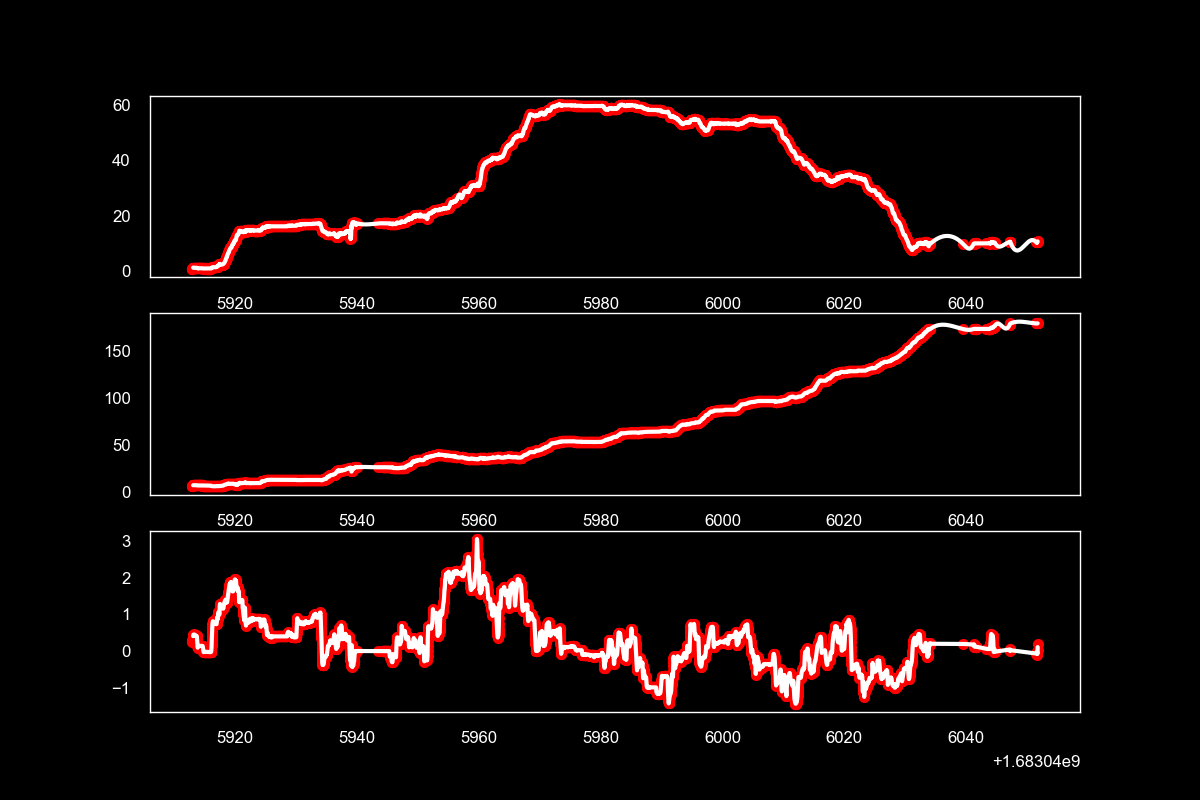

In [69]:
# interpolate?
# x is tstamp, y = anything
f_interp_y = sp.interpolate.interp1d(df_['time'], df_['ft_posy'], kind='cubic', 
                                   assume_sorted=False)
f_interp_x = sp.interpolate.interp1d(df_['time'], df_['ft_posx'], kind='cubic', 
                                   assume_sorted=False)
heading_interp = circular_interpolation(mt_['cputime'], 
                                    df_['time'], df_['ft_heading'], discont=2*np.pi, period=2*np.pi)
heading_interp_rewrap = (heading_interp + np.pi) % (2 * np.pi) - np.pi

y_interp = f_interp_y(mt_['cputime'])
x_interp = f_interp_x(mt_['cputime'])

fig, axn =pl.subplots(3, 1)
ax=axn[0]
ax.plot(df_['time'], df_['ft_posx'], 'r.')
ax.plot(mt_['cputime'], x_interp, 'w')
ax=axn[1]
ax.plot(df_['time'], df_['ft_posy'], 'r.')
ax.plot(mt_['cputime'], y_interp, 'w')
ax=axn[2]
ax.plot(df_['time'], df_['ft_heading'], 'r.')
ax.plot(mt_['cputime'], heading_interp_rewrap, 'w')

In [81]:
# update video df
mt_['ft_posy'] = y_interp
mt_['ft_posx'] = x_interp
mt_['ft_heading'] = heading_interp_rewrap

#### load video, get props

In [82]:
cap = cv2.VideoCapture(vid_fpath)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(frame_count), meta.shape

99916.0


(None, (99916, 6))

In [83]:
min_heading = np.deg2rad(-30)
max_heading = np.deg2rad(30)

infront = mt_[(mt_['ft_heading']<=max_heading) & (mt_['ft_heading']>=min_heading)].copy()
infront.shape

(5212, 9)

<IPython.core.display.Javascript object>


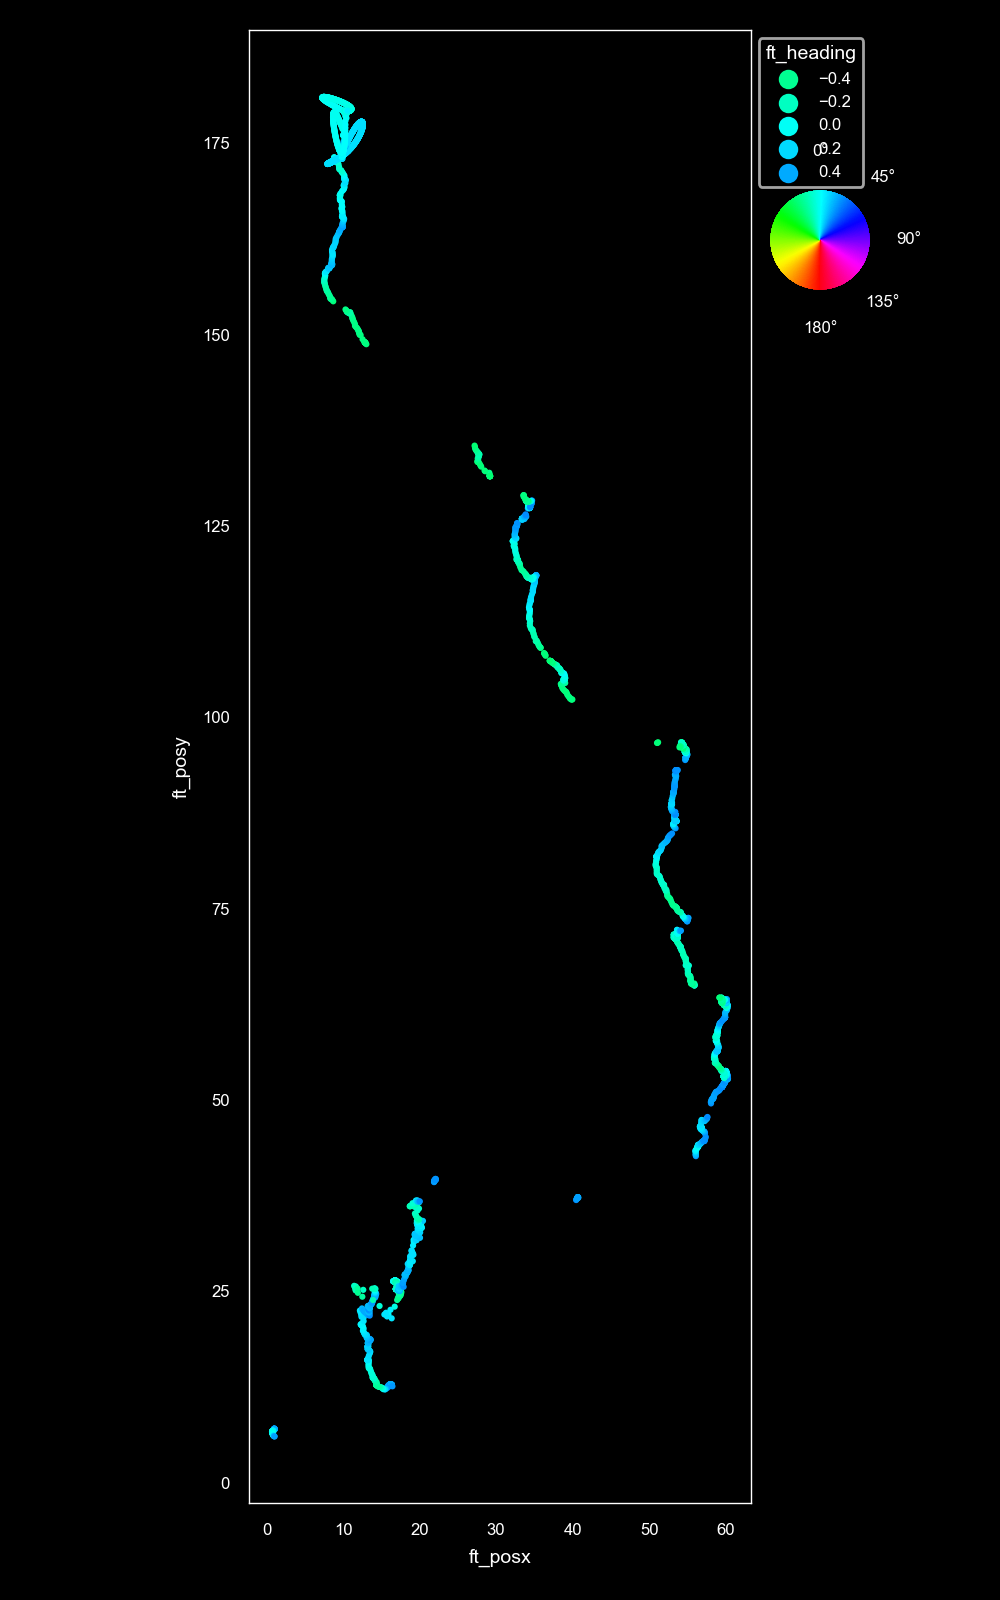

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_37606/1835840691.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


In [84]:
hue_min = -np.pi
hue_max = np.pi
hue_norm = mpl.colors.Normalize(vmin=hue_min, vmax=hue_max)

fig, ax = pl.subplots(figsize=(5, 8))
sns.scatterplot(data=infront, x='ft_posx', y='ft_posy', hue='ft_heading', ax=ax,
               palette='hsv', s=5, edgecolor='none', hue_norm=hue_norm)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1))
putil.add_colorwheel(fig, axes=[0.77, 0.8, 0.1, 0.1])
ax.set_aspect('equal')
pl.tight_layout()

In [85]:
currdf = infront[(infront['ft_posy']>=100) & (infront['ft_posy']<=125)]
currdf.head()

cputime  framecount  frameid    serial     sestime   timestamp  \
5997  1.683046e+09        5998     5998  24516213  117.976368  117.953411   
5998  1.683046e+09        5999     5999  24516213  117.993018  117.970073   
5999  1.683046e+09        6000     6000  24516213  118.009255  117.986734   
6000  1.683046e+09        6001     6001  24516213  118.026883  118.003396   
6001  1.683046e+09        6002     6002  24516213  118.042800  118.020058   

         ft_posy    ft_posx  ft_heading  
5997  102.350482  39.971273   -0.513505  
5998  102.360790  39.897838   -0.502690  
5999  102.344343  39.833923   -0.492511  
6000  102.432594  39.720282   -0.486086  
6001  102.514785  39.638262   -0.479620

In [107]:
nframes = currdf['frameid'].max() - currdf['frameid'].min()

In [108]:
currdf.shape

(290, 9)

In [119]:
currdf[(currdf['frameid']>6210) & (currdf['frameid']<6220)]

cputime  framecount  frameid    serial     sestime   timestamp  \
6210  1.683046e+09        6211     6211  24516213  121.525300  121.502405   
6211  1.683046e+09        6212     6212  24516213  121.542400  121.519067   
6212  1.683046e+09        6213     6213  24516213  121.558848  121.535729   
6213  1.683046e+09        6214     6214  24516213  121.574906  121.552391   
6214  1.683046e+09        6215     6215  24516213  121.592894  121.569053   
6215  1.683046e+09        6216     6216  24516213  121.608692  121.585715   
6216  1.683046e+09        6217     6217  24516213  121.625572  121.602377   
6217  1.683046e+09        6218     6218  24516213  121.642391  121.619039   
6218  1.683046e+09        6219     6219  24516213  121.658927  121.635701   

         ft_posy    ft_posx  ft_heading  
6210  118.201816  34.814874   -0.019329  
6211  118.189189  34.808076   -0.015825  
6212  118.188732  34.816413   -0.015597  
6213  118.195119  34.815906   -0.015283  
6214  118.189120  34.816066   -0.015867  
6215  118.159557  34.798143   -0.015025  
6216  118.131739  34.768263   -0.009499  
6217  118.074553  34.755386   -0.001136  
6218  118.043478  34.713061    0.009204

In [109]:
frames=[]
frame_ix=[]
s_ix = currdf['frameid'].iloc[0]
e_ix = currdf['frameid'].iloc[-1]
curr_frame_ixs = currdf[(currdf['frameid']>6210) & (currdf['frameid']<6220)]['frameid']
for i in np.arange(0, nframes):
    curr_frame = s_ix+i
    cap.set(1, curr_frame)
    ret, frame = cap.read()
    frames.append(frame)
    frame_ix.append(curr_frame)

In [121]:
frame_ix

[5998,
 5999,
 6000,
 6001,
 6002,
 6003,
 6004,
 6005,
 6006,
 6007,
 6008,
 6009,
 6010,
 6011,
 6012,
 6013,
 6014,
 6015,
 6016,
 6017,
 6018,
 6019,
 6020,
 6021,
 6022,
 6023,
 6024,
 6025,
 6026,
 6027,
 6028,
 6029,
 6030,
 6031,
 6032,
 6033,
 6034,
 6035,
 6036,
 6037,
 6038,
 6039,
 6040,
 6041,
 6042,
 6043,
 6044,
 6045,
 6046,
 6047,
 6048,
 6049,
 6050,
 6051,
 6052,
 6053,
 6054,
 6055,
 6056,
 6057,
 6058,
 6059,
 6060,
 6061,
 6062,
 6063,
 6064,
 6065,
 6066,
 6067,
 6068,
 6069,
 6070,
 6071,
 6072,
 6073,
 6074,
 6075,
 6076,
 6077,
 6078,
 6079,
 6080,
 6081,
 6082,
 6083,
 6084,
 6085,
 6086,
 6087,
 6088,
 6089,
 6090,
 6091,
 6092,
 6093,
 6094,
 6095,
 6096,
 6097,
 6098,
 6099,
 6100,
 6101,
 6102,
 6103,
 6104,
 6105,
 6106,
 6107,
 6108,
 6109,
 6110,
 6111,
 6112,
 6113,
 6114,
 6115,
 6116,
 6117,
 6118,
 6119,
 6120,
 6121,
 6122,
 6123,
 6124,
 6125,
 6126,
 6127,
 6128,
 6129,
 6130,
 6131,
 6132,
 6133,
 6134,
 6135,
 6136,
 6137,
 6138,
 6139,
 6140,

In [111]:
print(figdir)

/Volumes/Julie/courtship-tethered/behavior/P1_activation/figures


In [112]:
figdir_tmp = os.path.join(figdir, 'f{}-{}'.format(s_ix, e_ix))
if not os.path.exists(figdir_tmp):
    os.makedirs(figdir_tmp)
print(figdir_tmp)

/Volumes/Julie/courtship-tethered/behavior/P1_activation/figures/f5998-6309


<IPython.core.display.Javascript object>


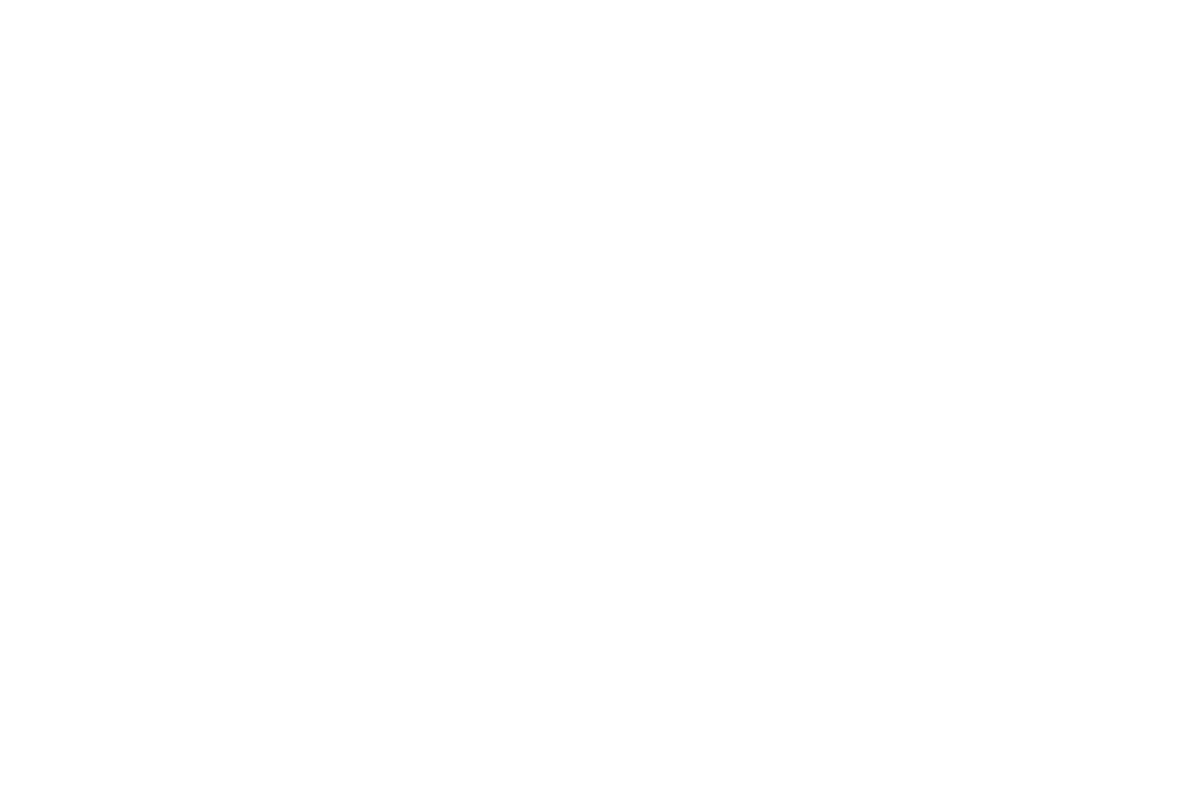

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_37606/1584720141.py:15: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


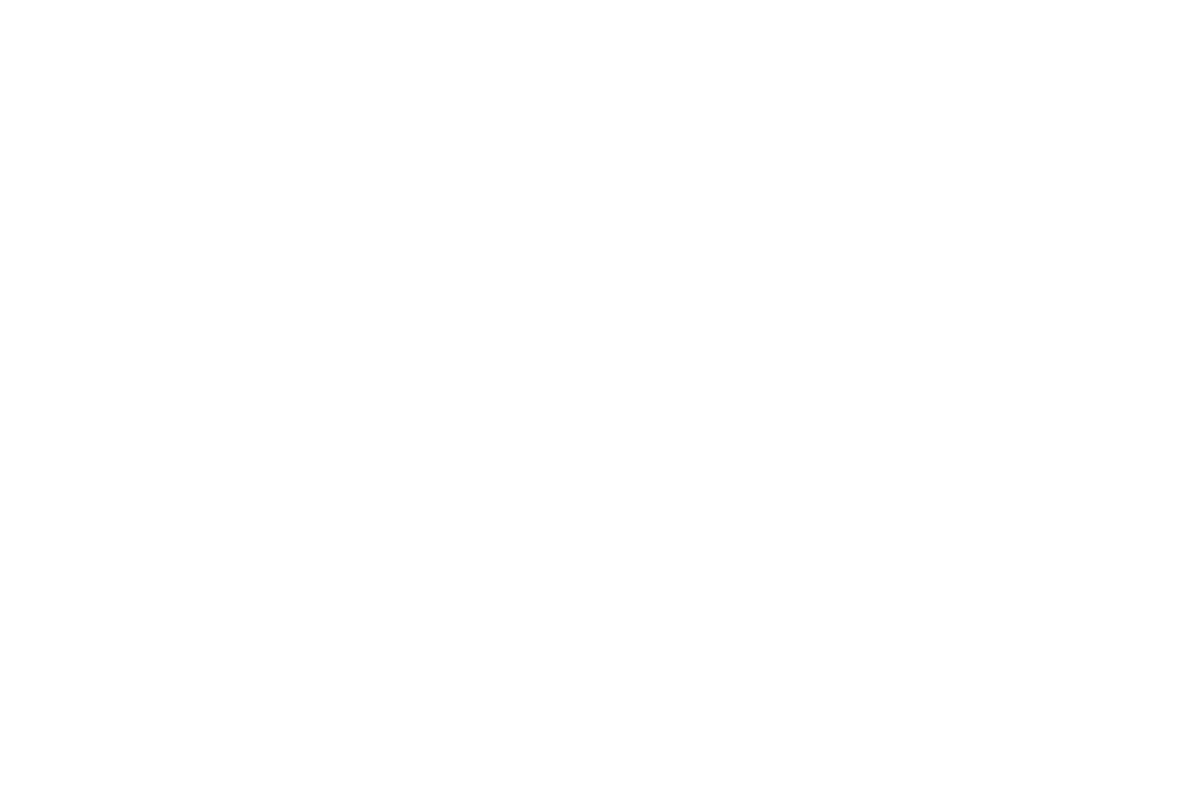

<IPython.core.display.Javascript object>


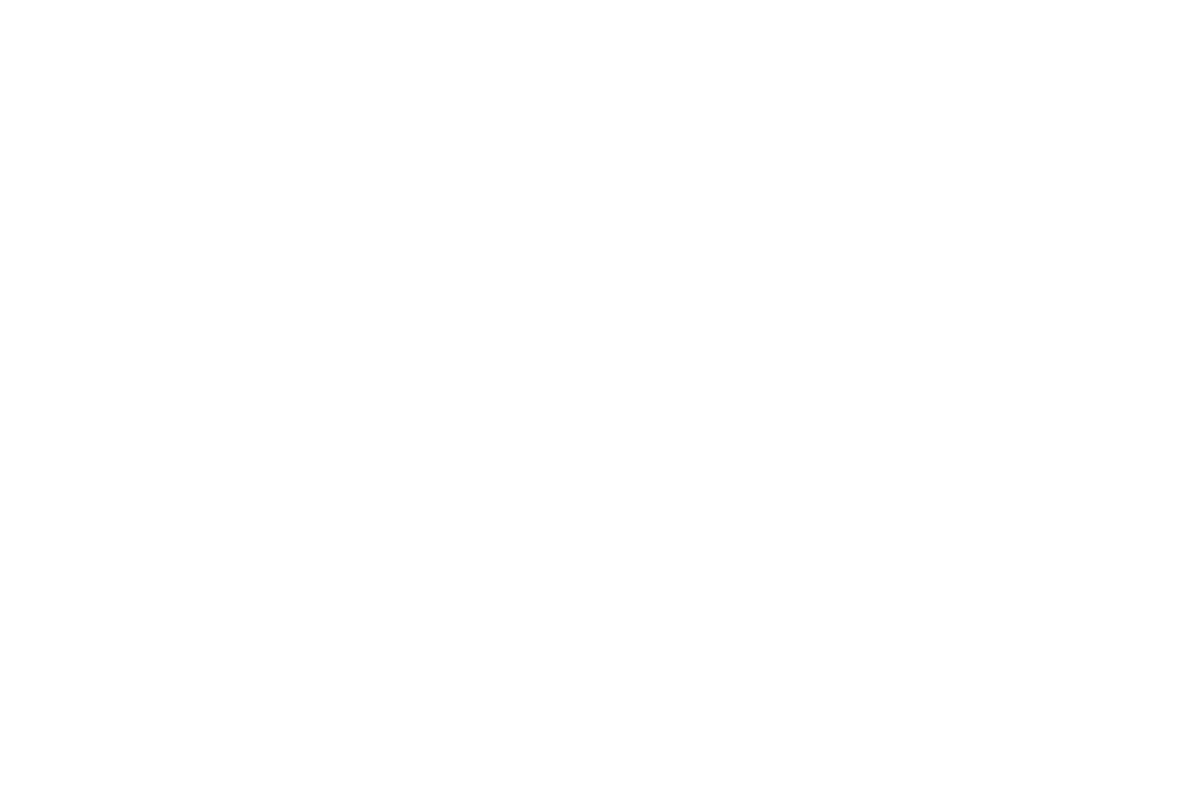

<IPython.core.display.Javascript object>


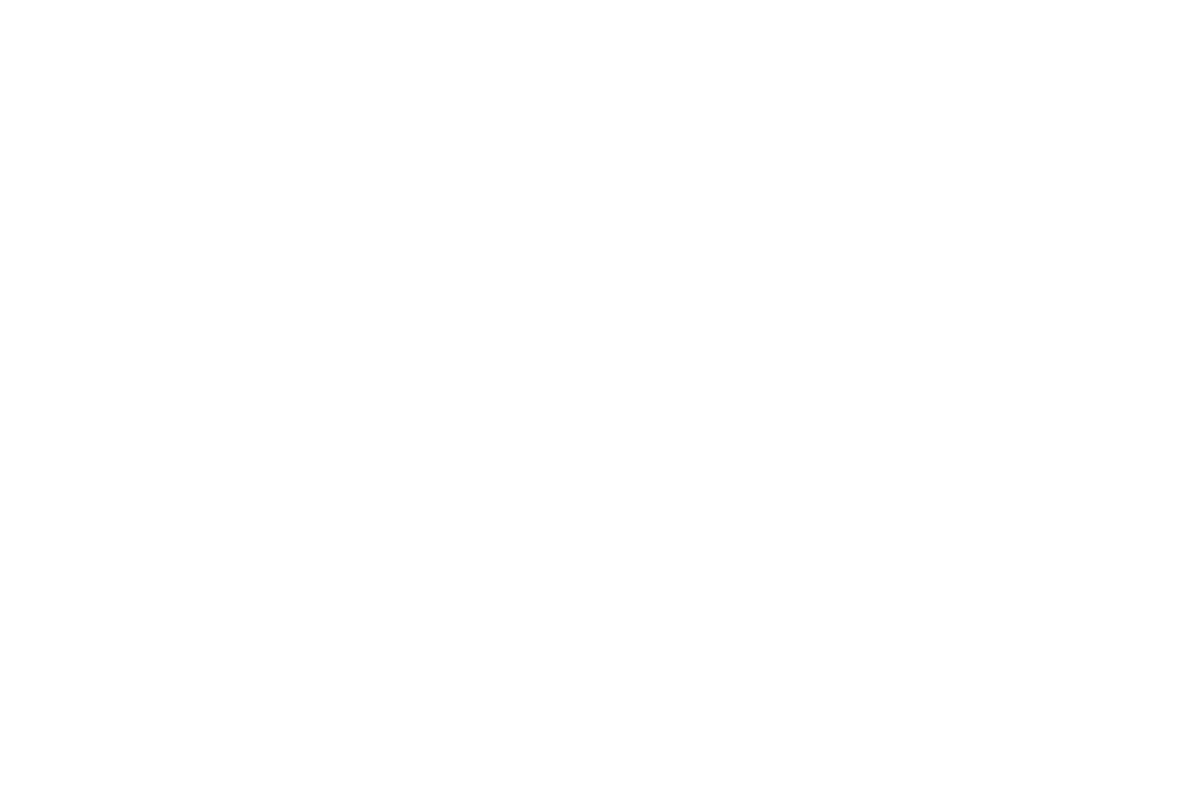

<IPython.core.display.Javascript object>


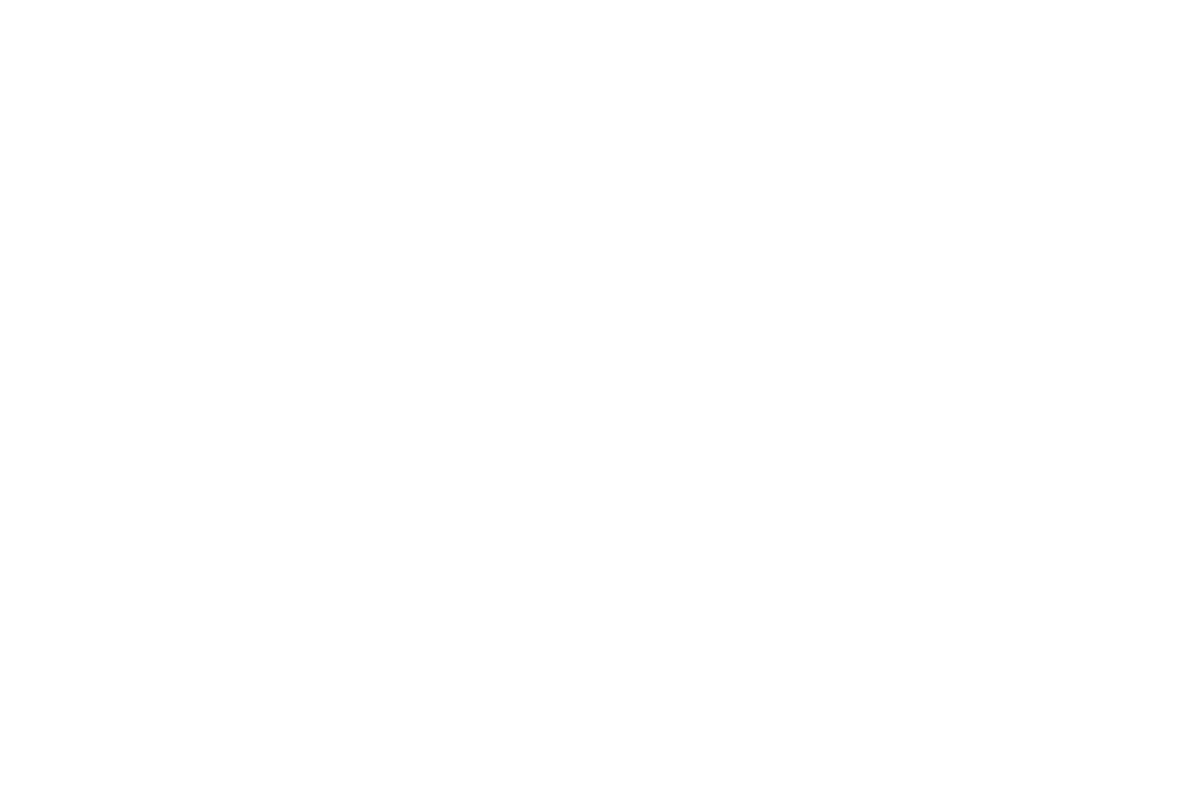

<IPython.core.display.Javascript object>


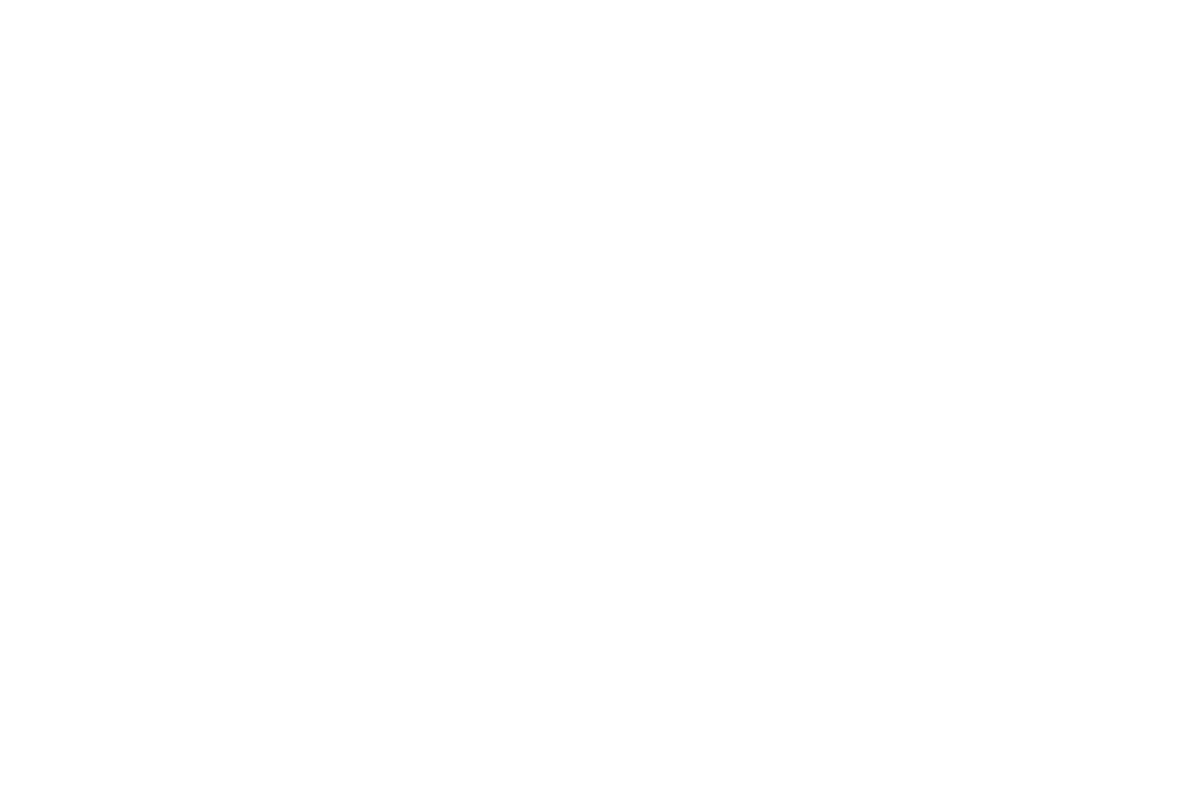

<IPython.core.display.Javascript object>


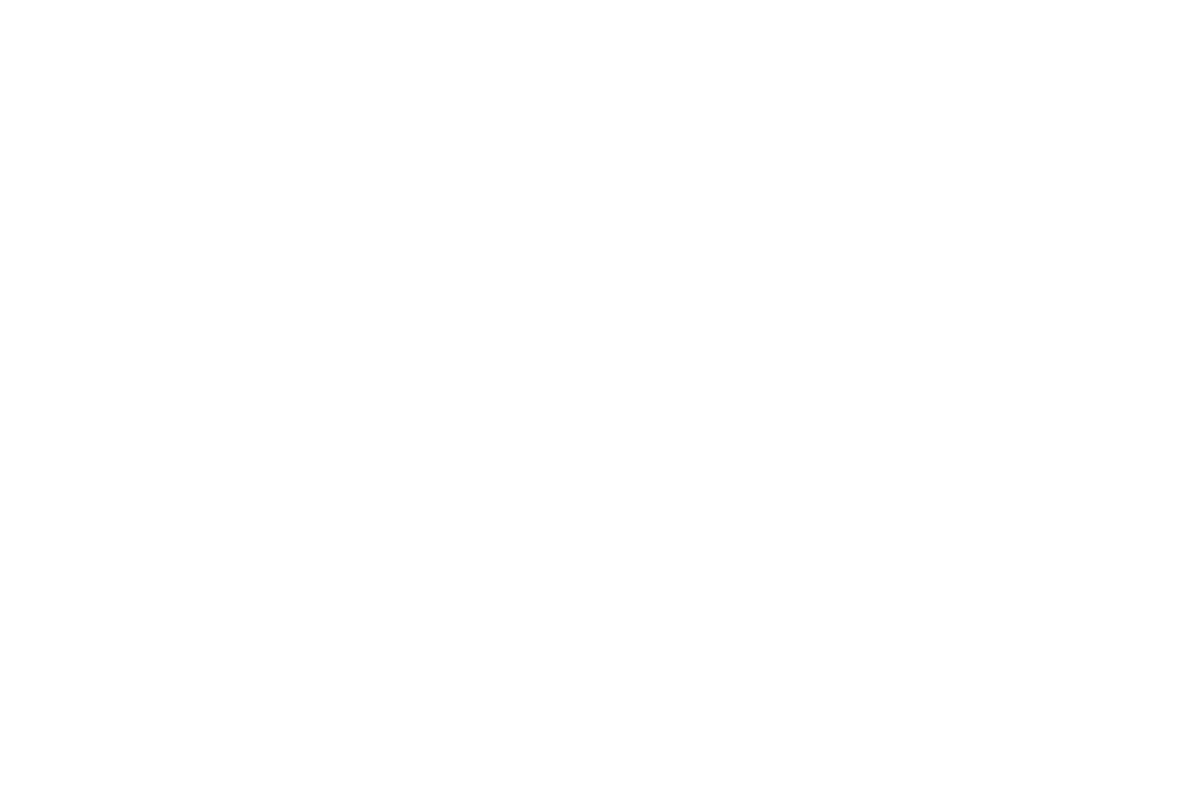

<IPython.core.display.Javascript object>


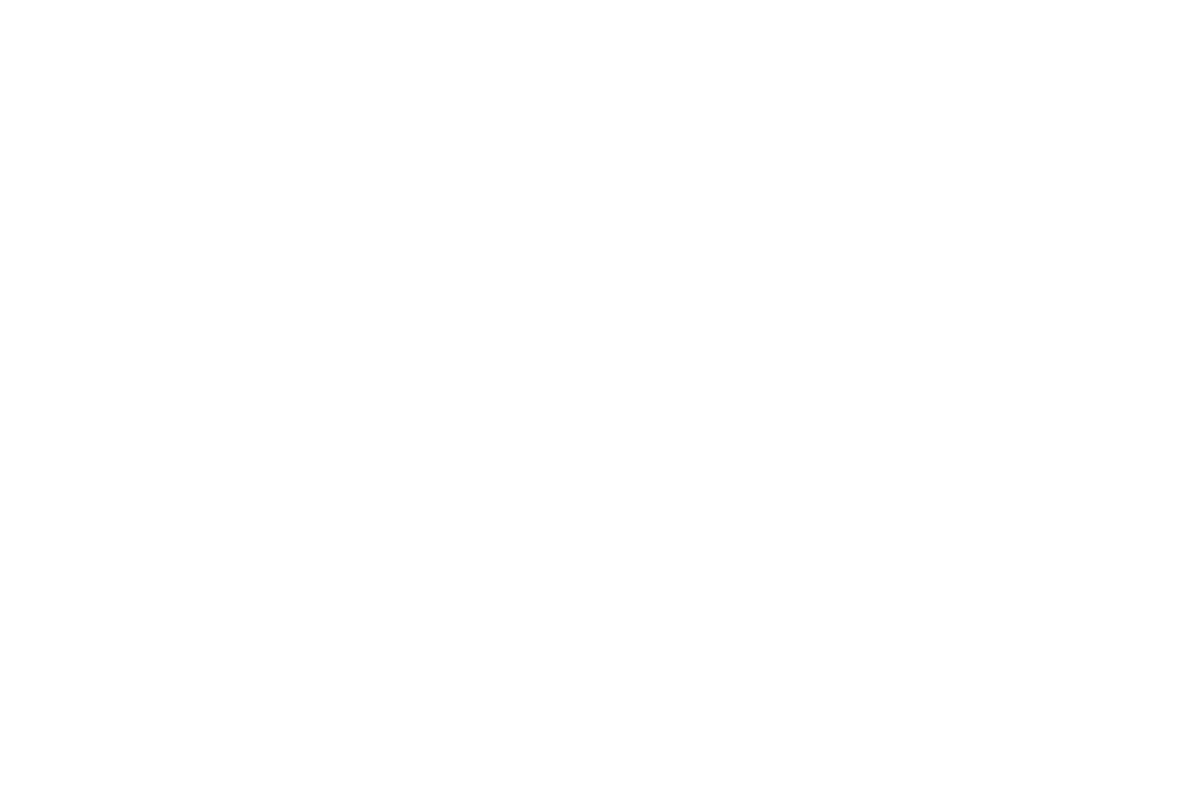

<IPython.core.display.Javascript object>


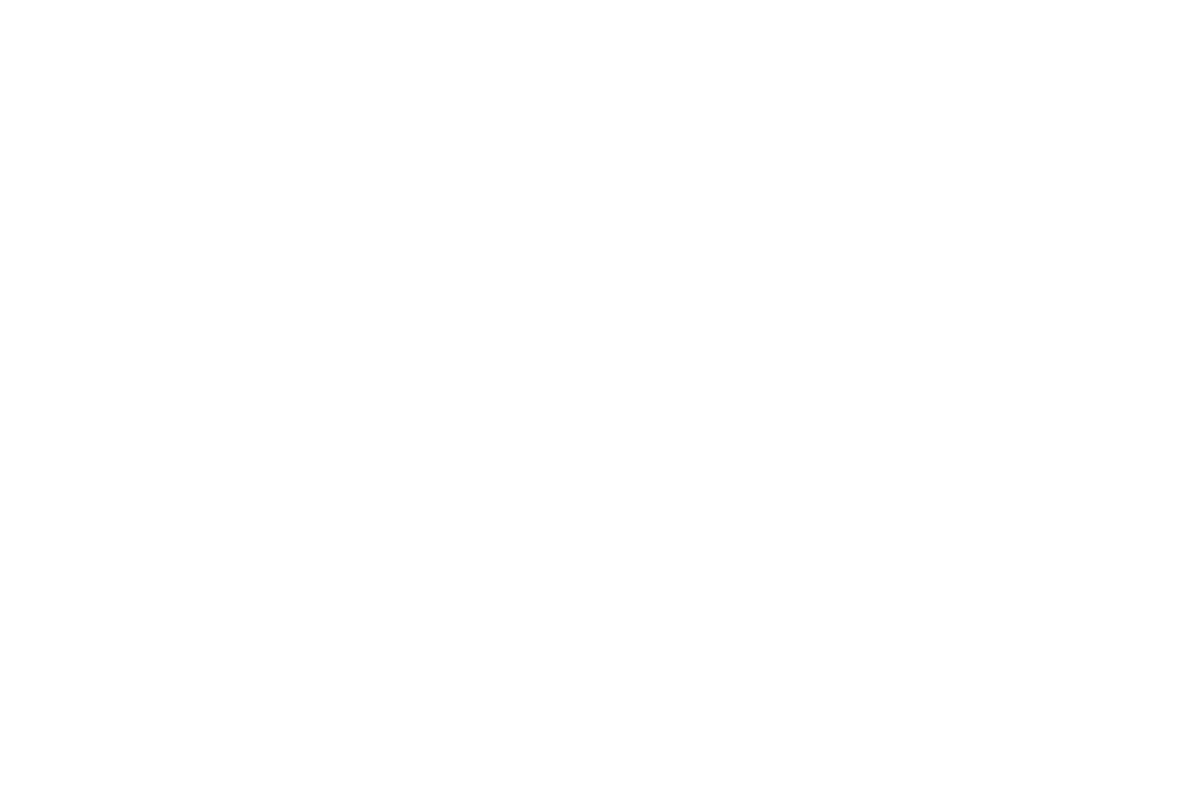

<IPython.core.display.Javascript object>


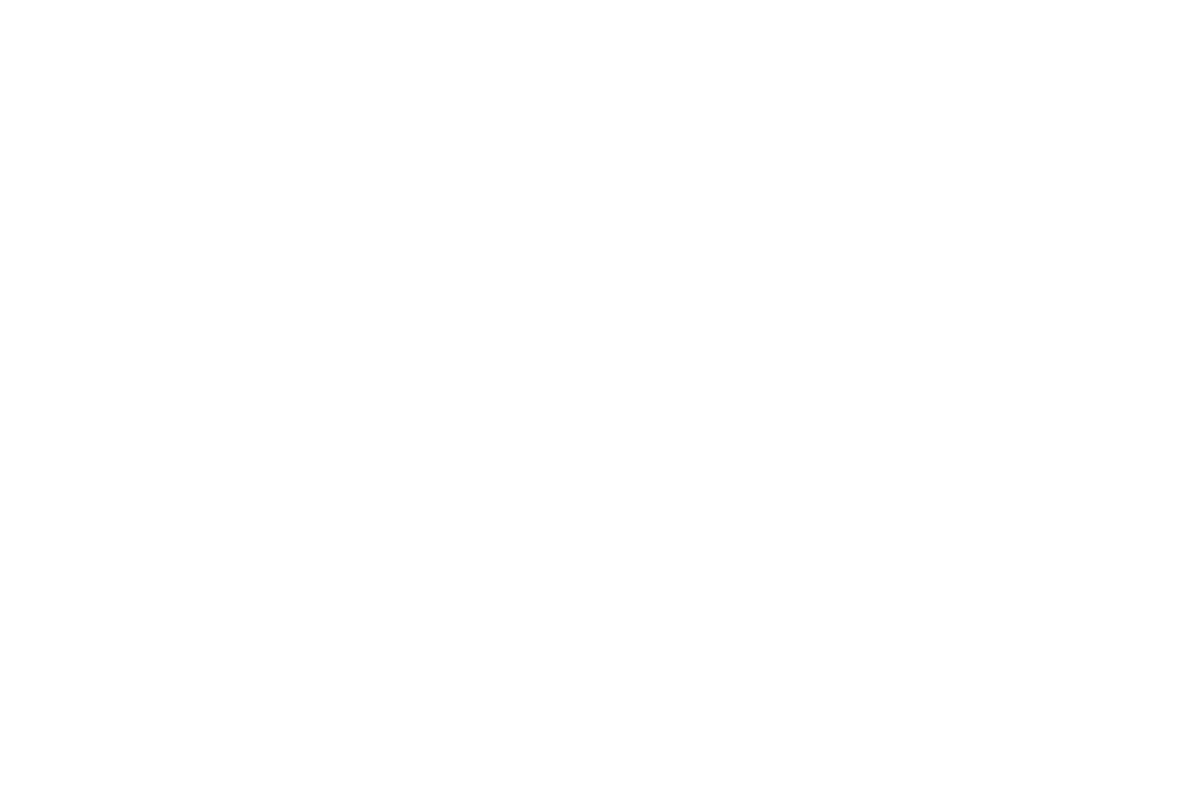

<IPython.core.display.Javascript object>


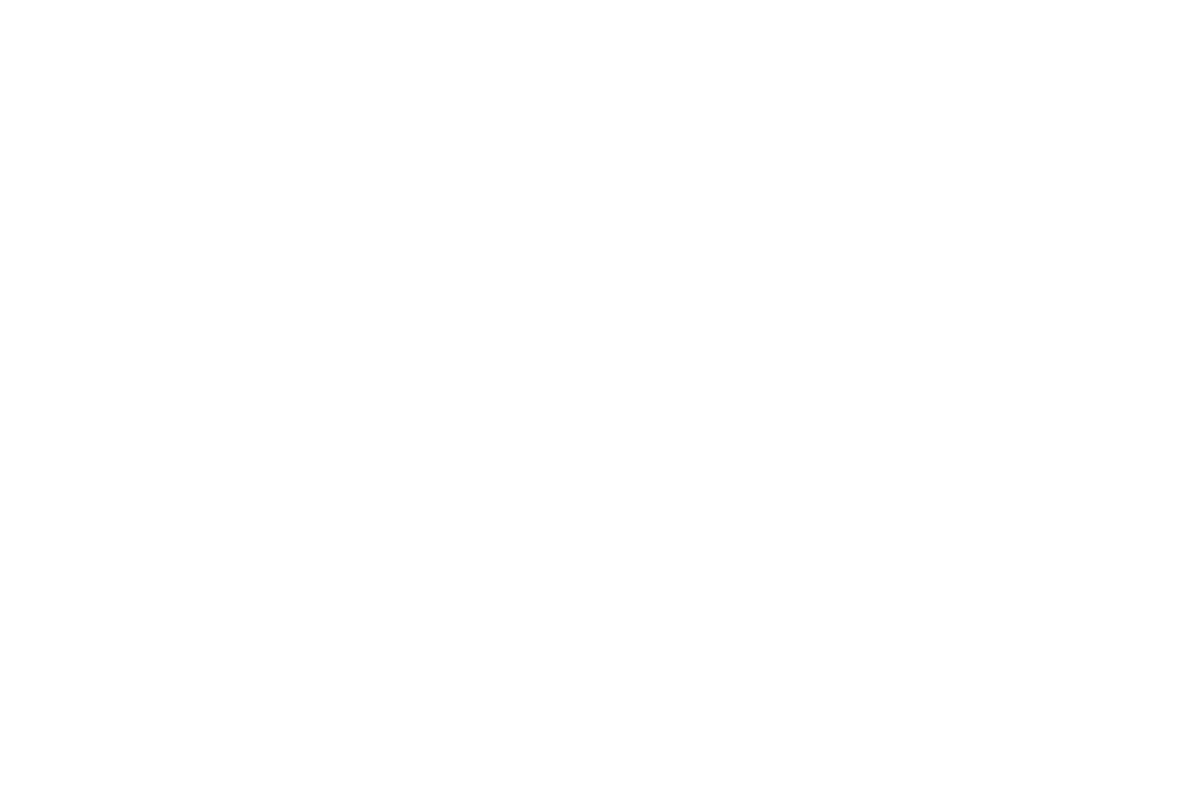

<IPython.core.display.Javascript object>


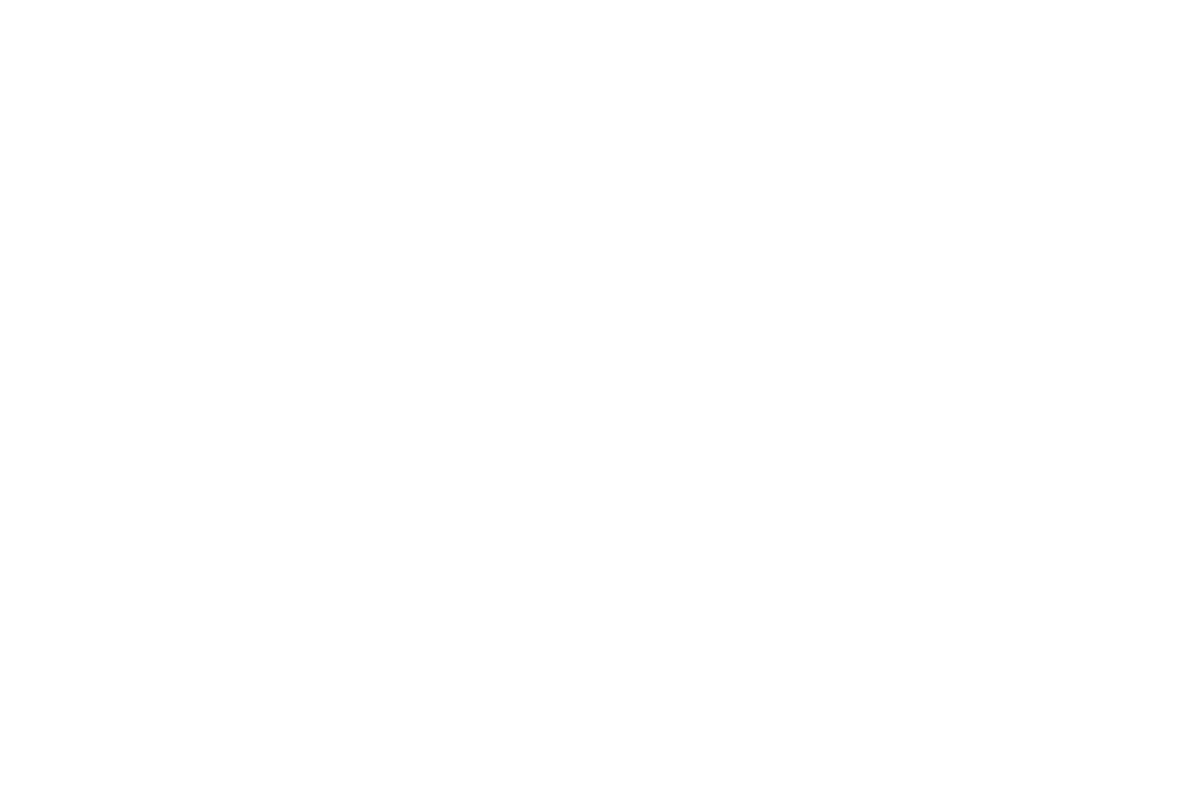

<IPython.core.display.Javascript object>


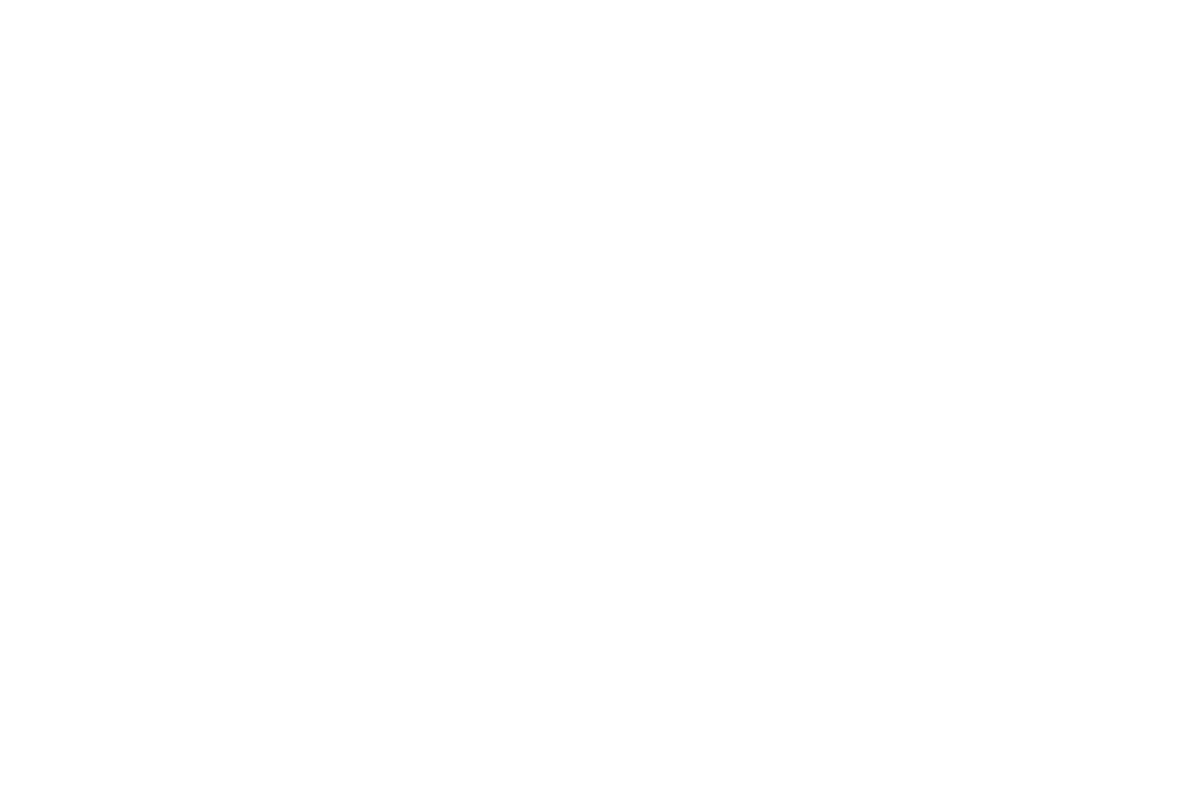

<IPython.core.display.Javascript object>


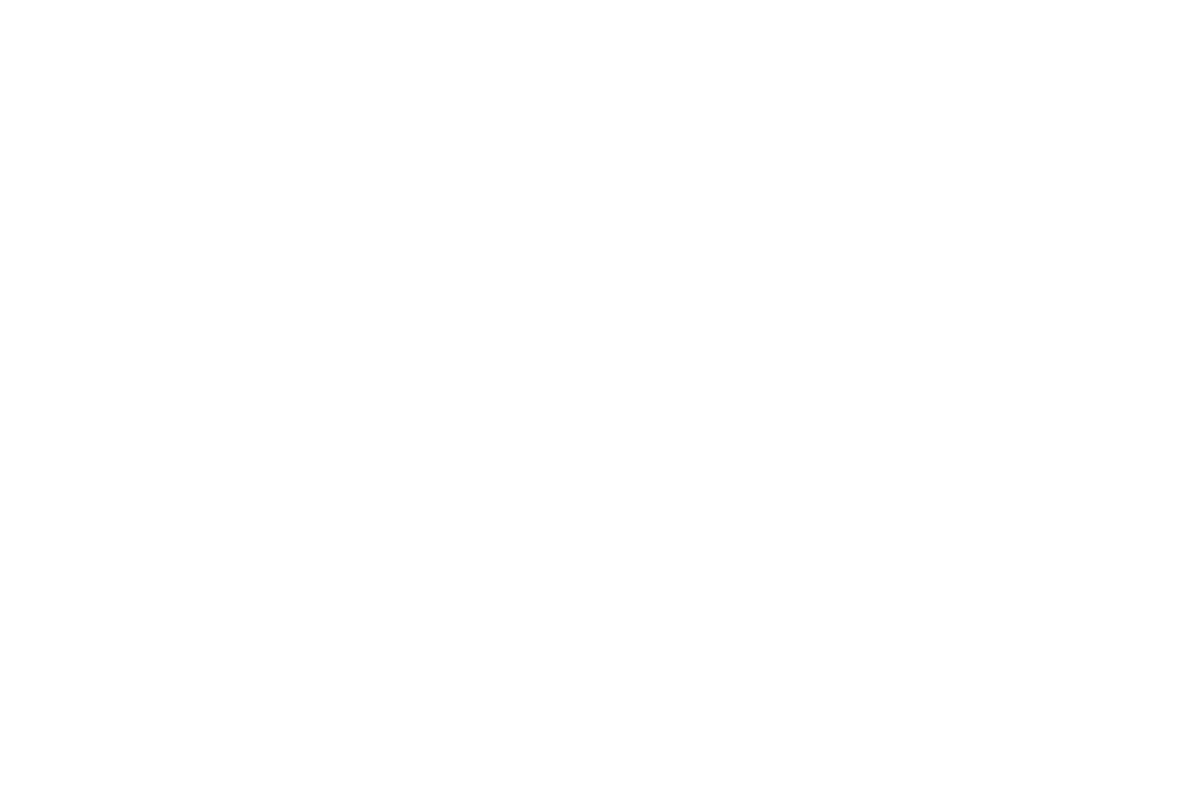

<IPython.core.display.Javascript object>


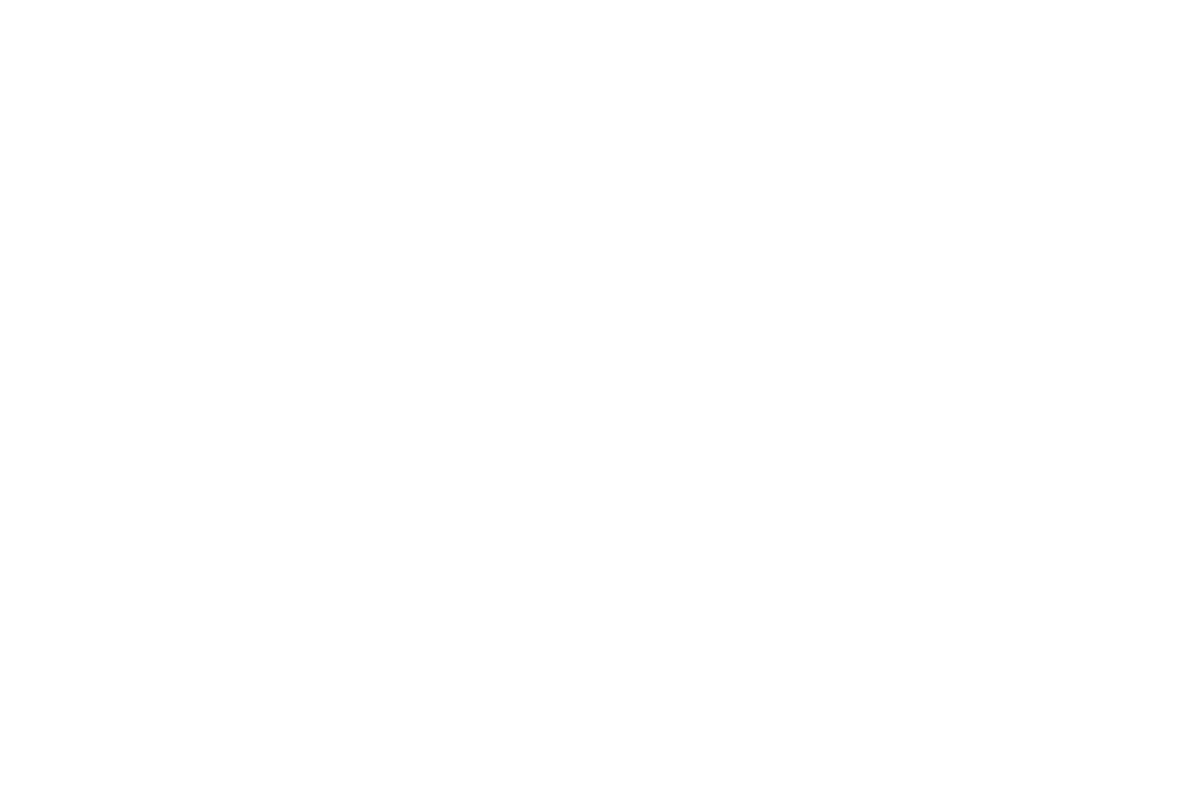

<IPython.core.display.Javascript object>


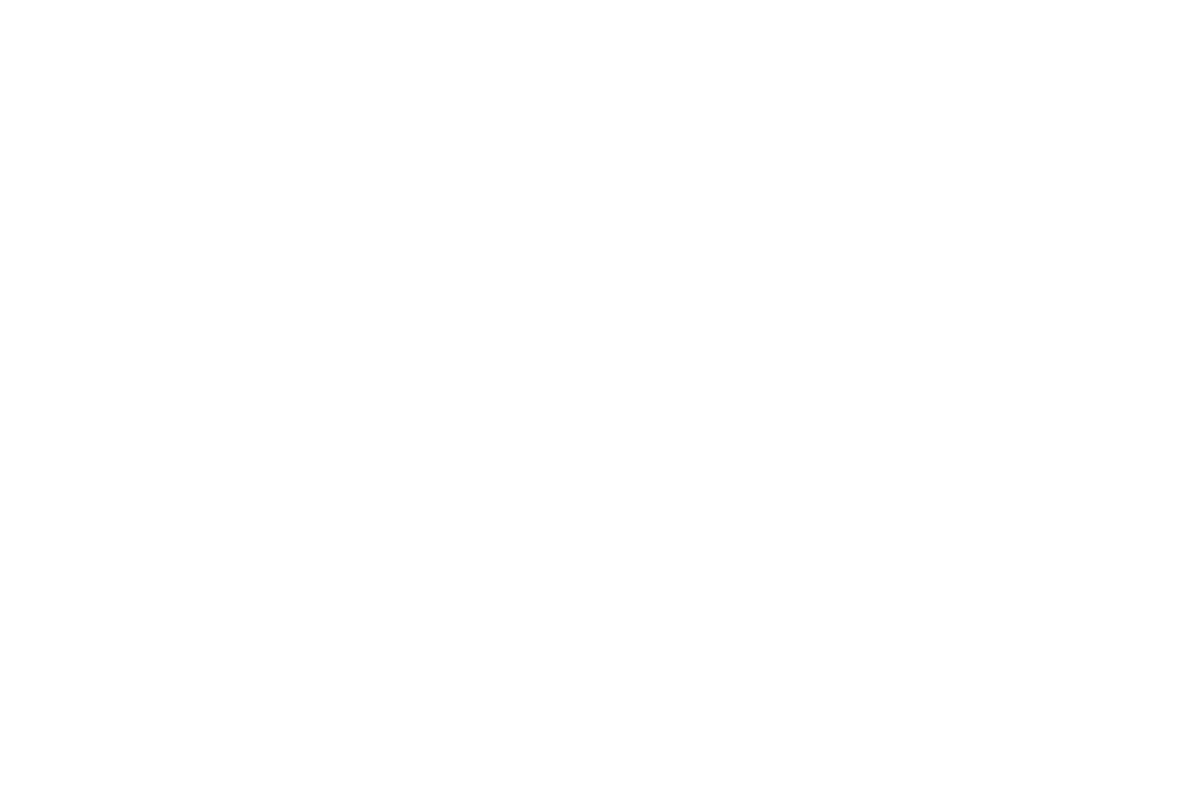

<IPython.core.display.Javascript object>


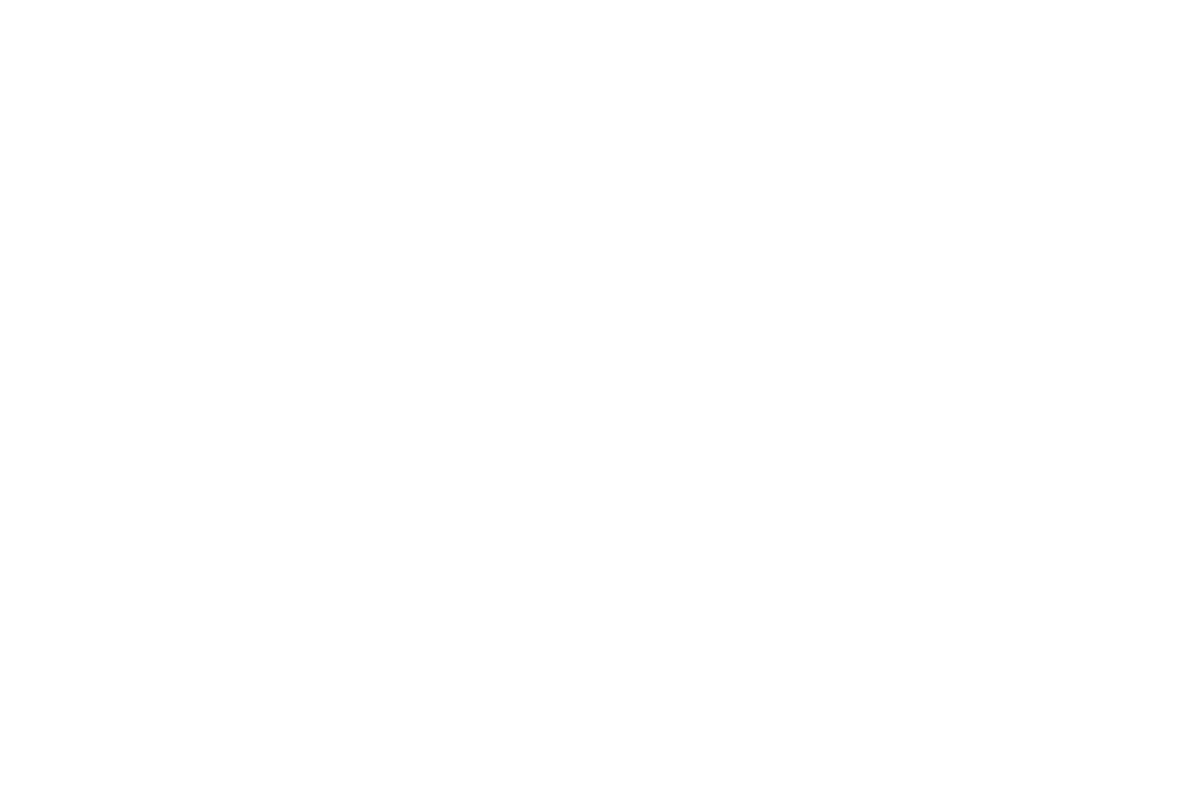

<IPython.core.display.Javascript object>


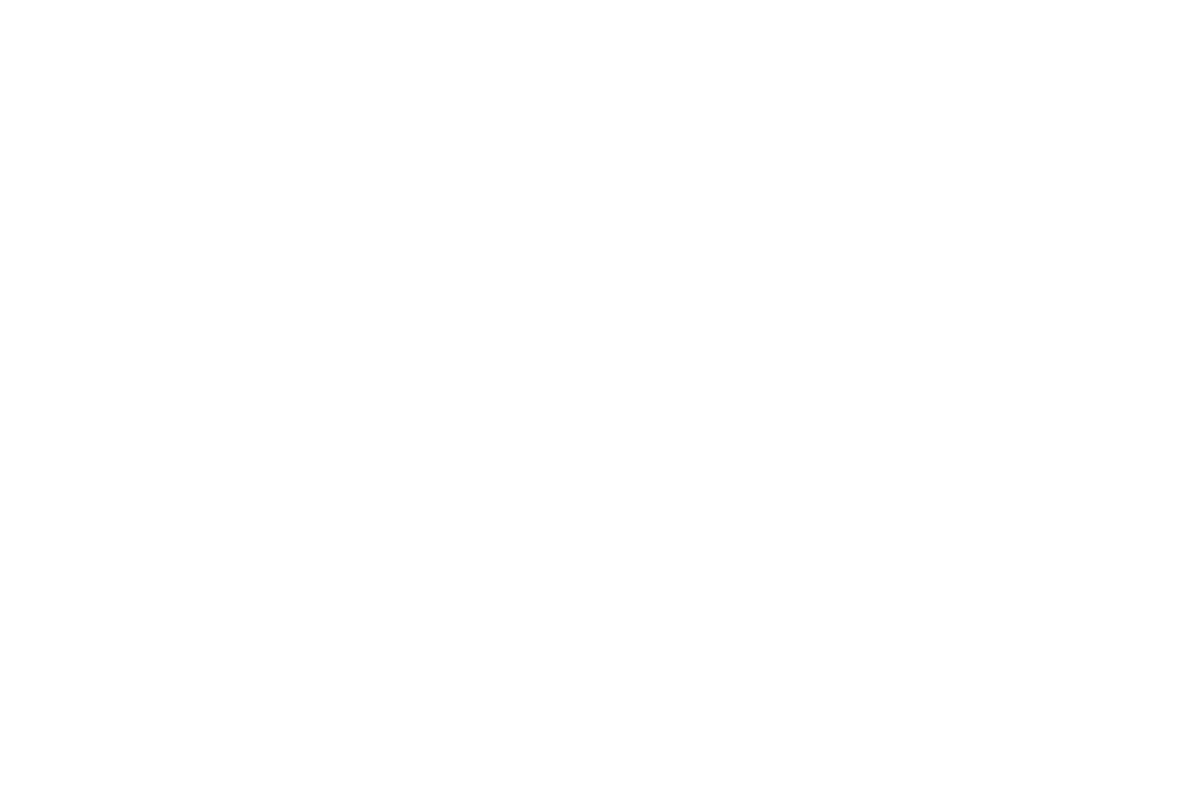

<IPython.core.display.Javascript object>


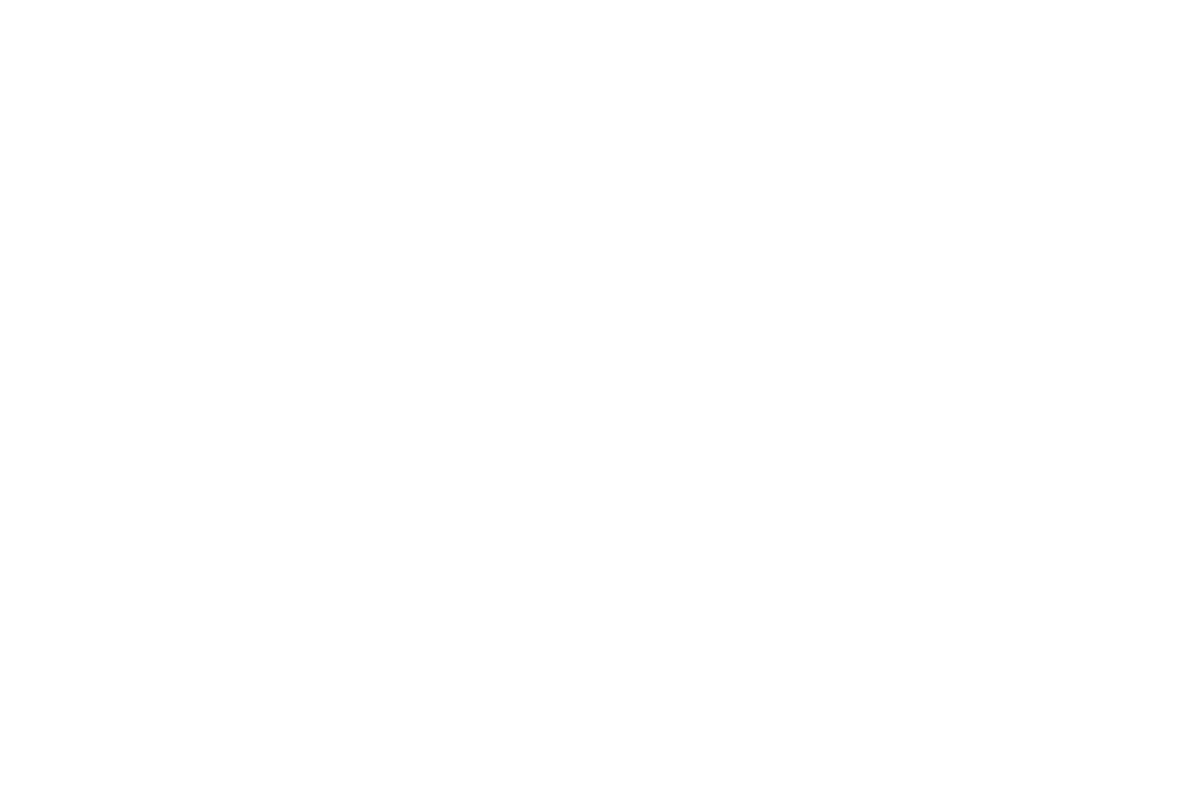

<IPython.core.display.Javascript object>


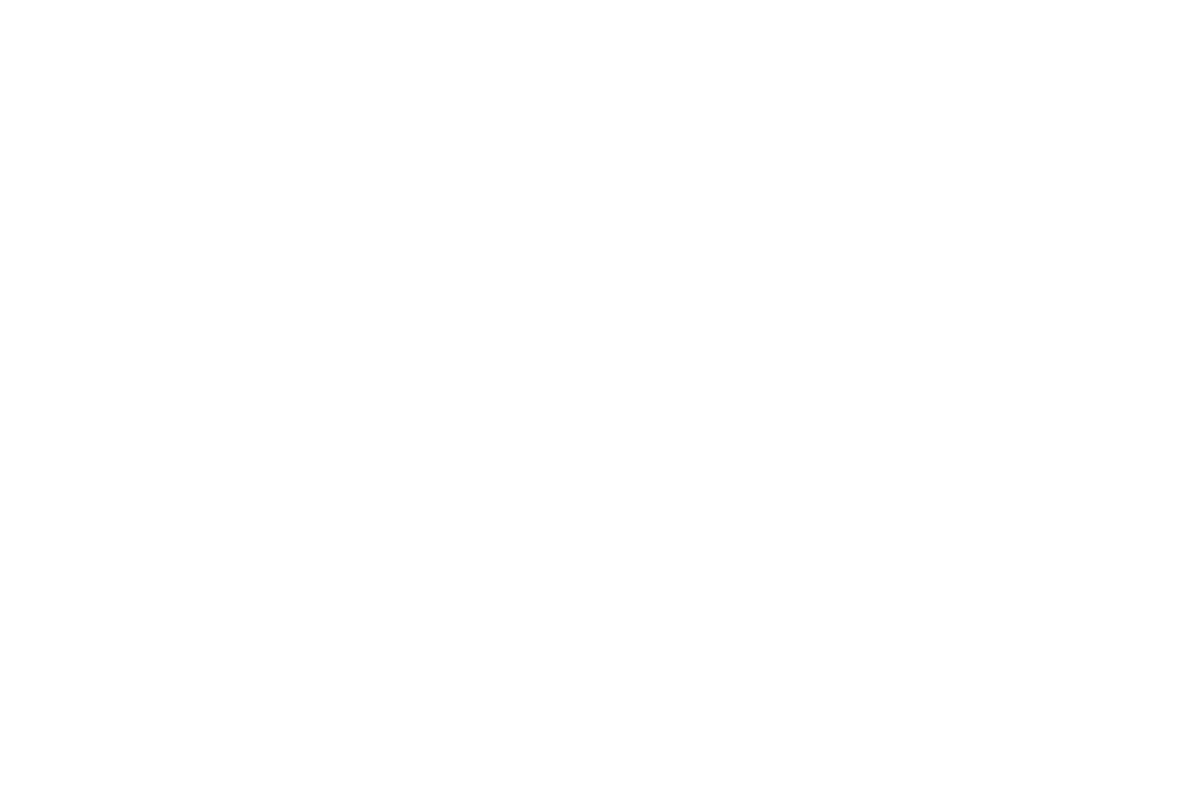

<IPython.core.display.Javascript object>


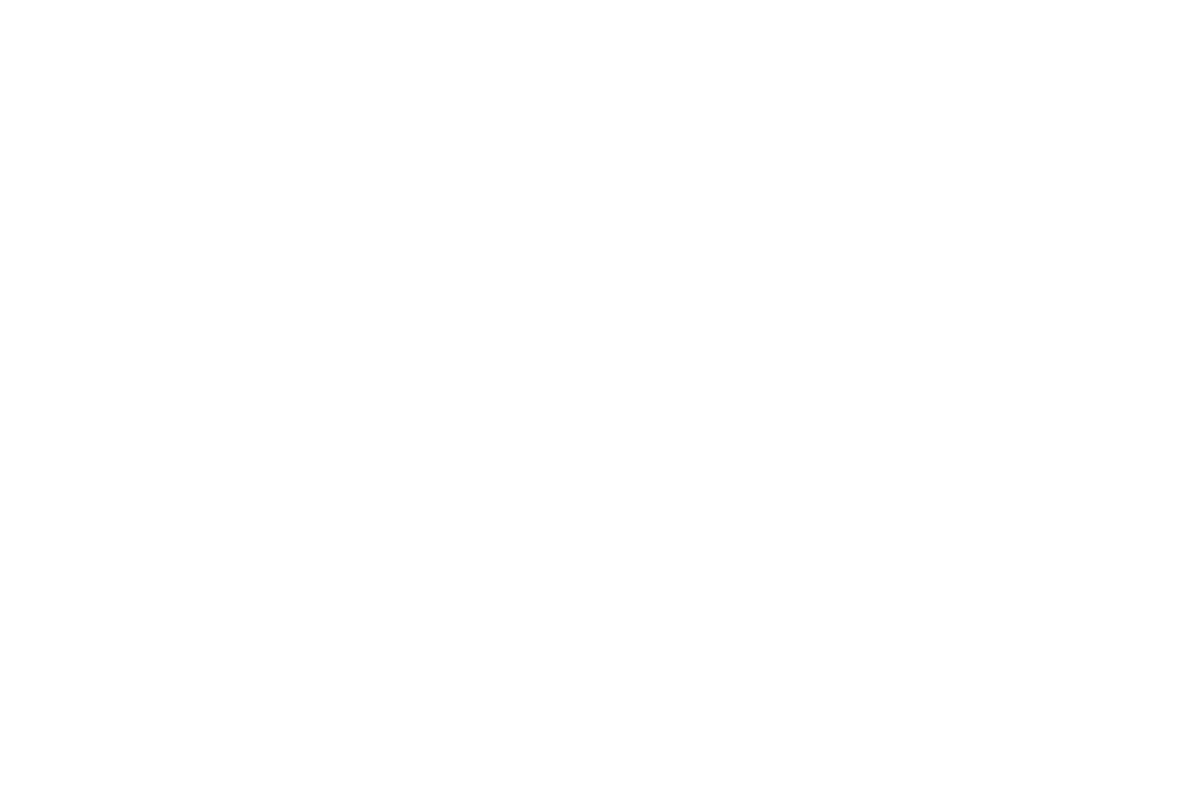

<IPython.core.display.Javascript object>


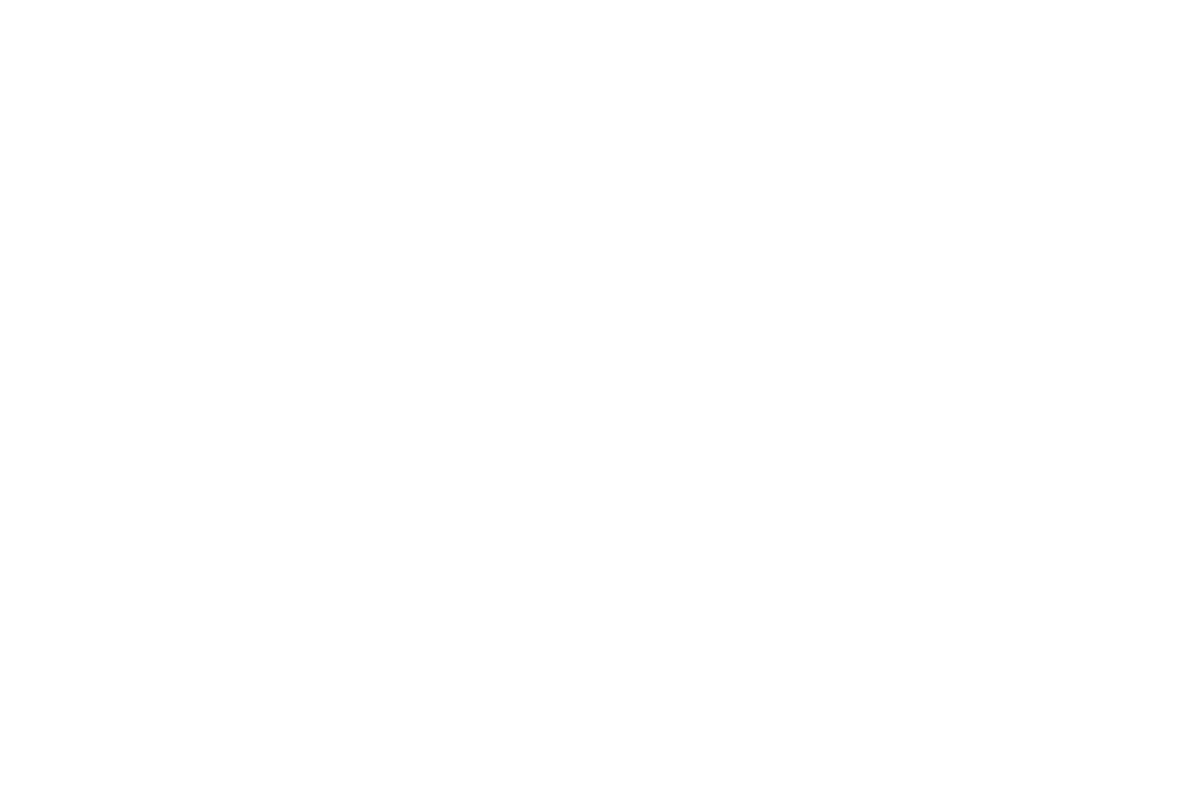

<IPython.core.display.Javascript object>


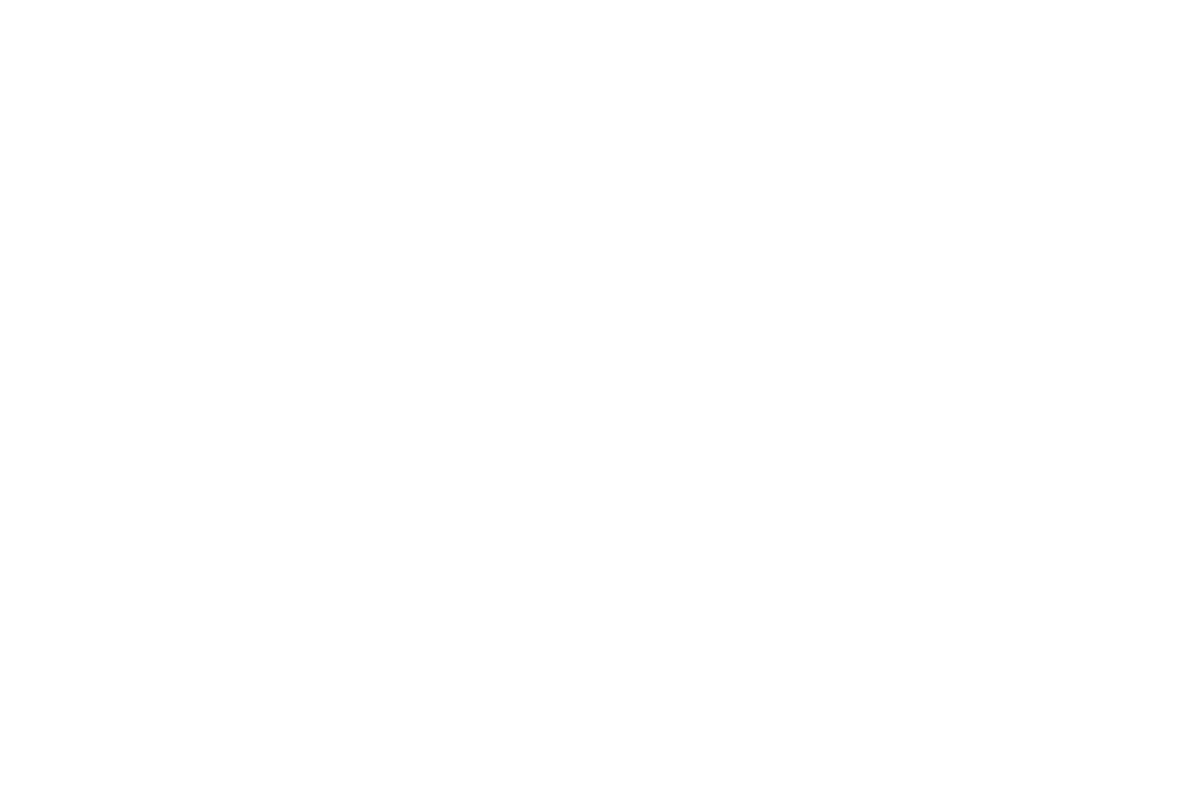

<IPython.core.display.Javascript object>


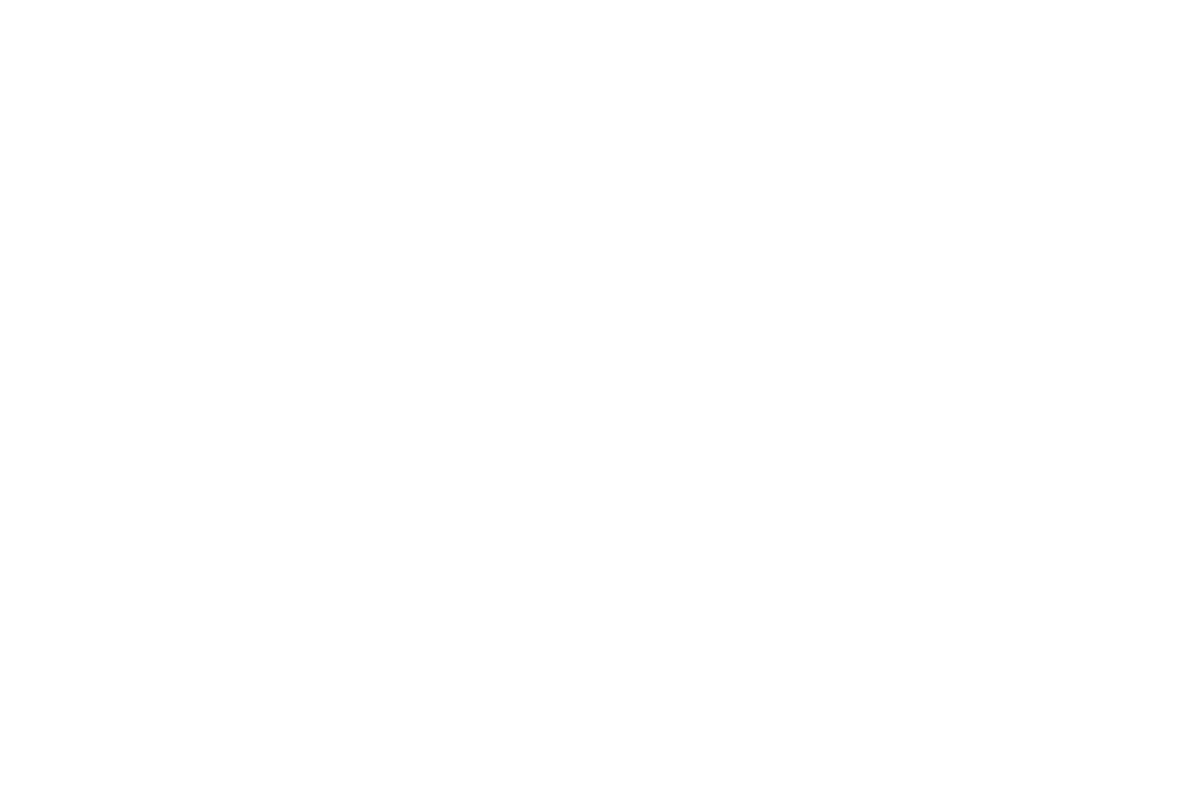

<IPython.core.display.Javascript object>


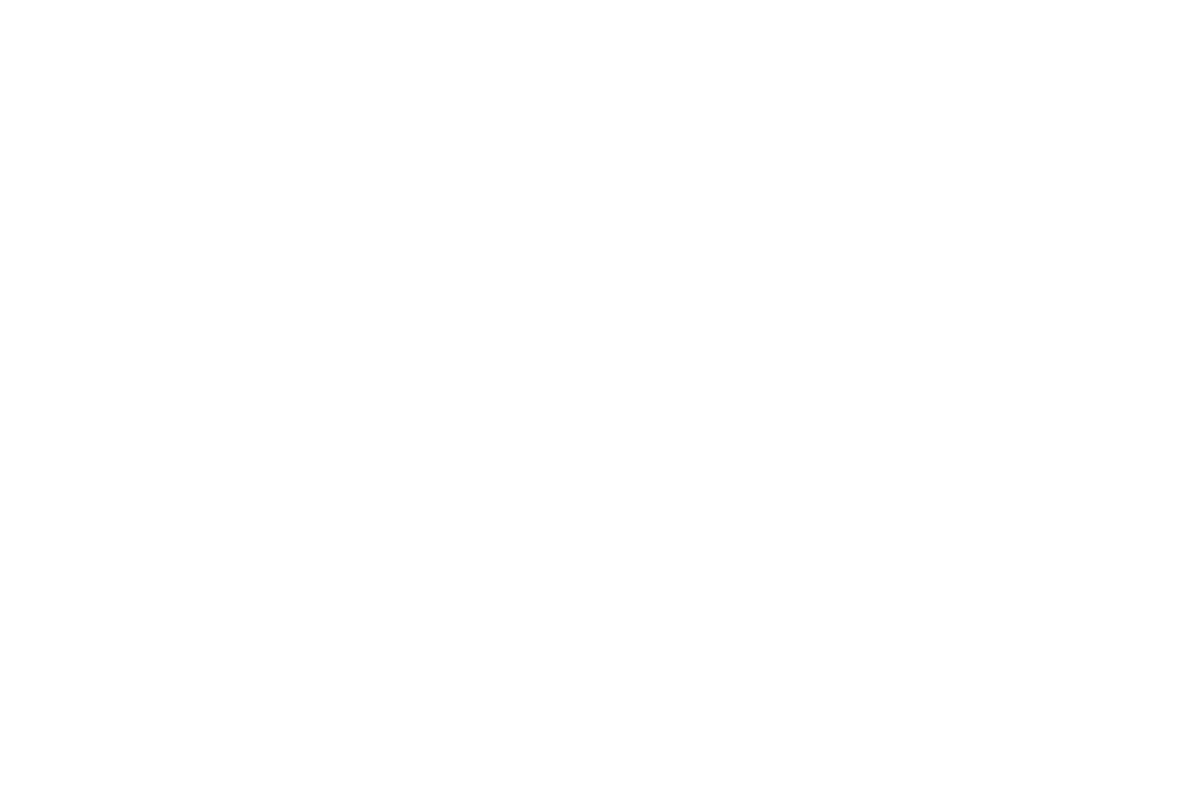

<IPython.core.display.Javascript object>


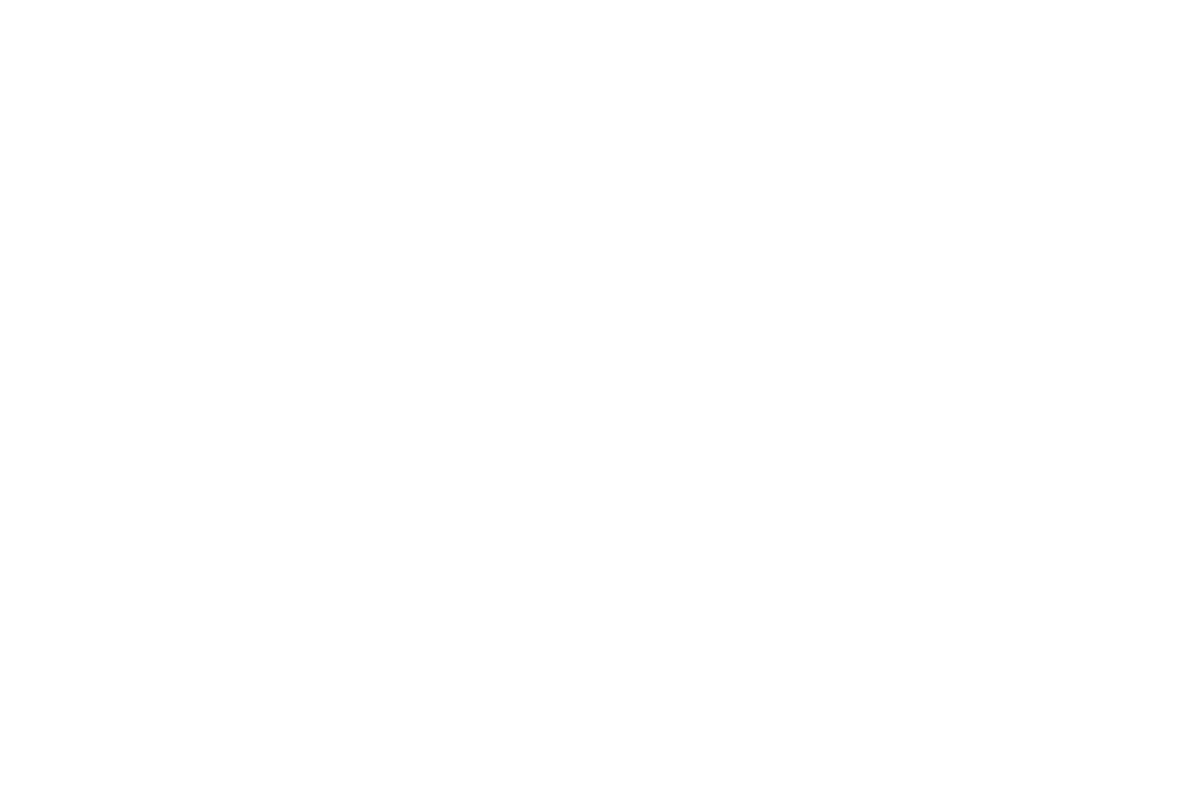

<IPython.core.display.Javascript object>


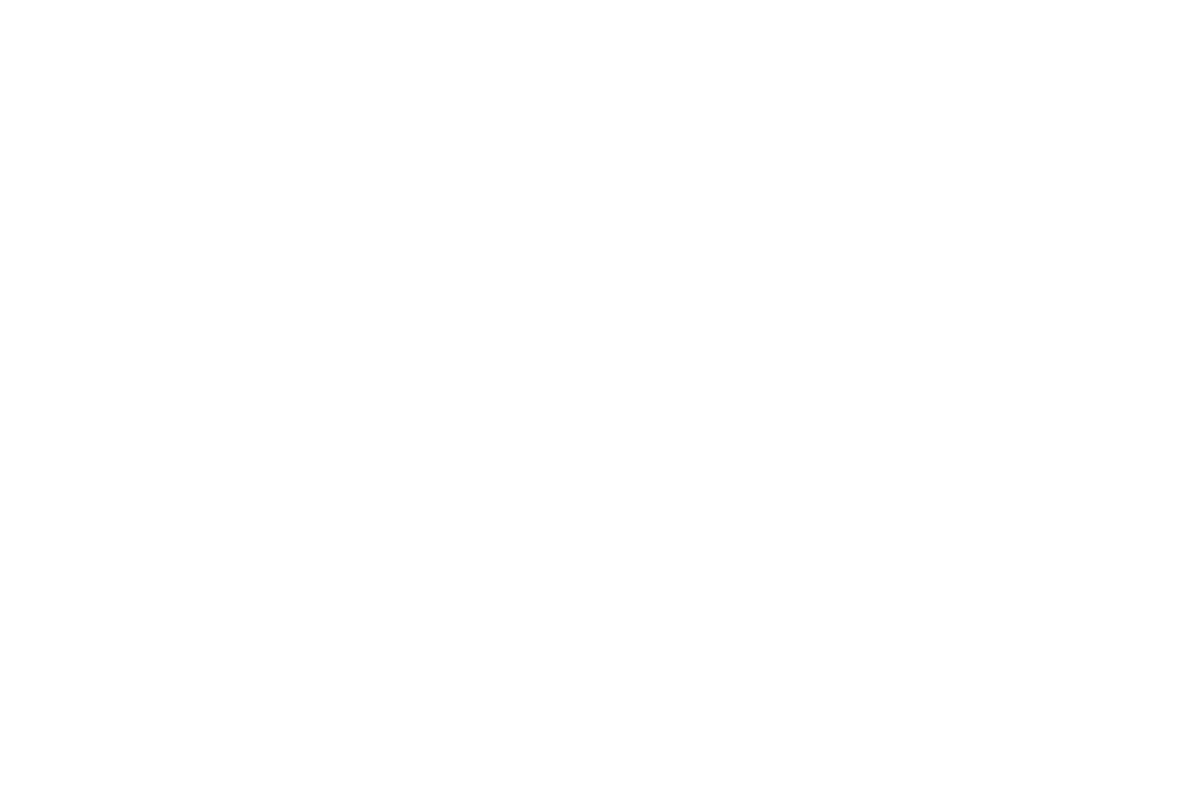

<IPython.core.display.Javascript object>


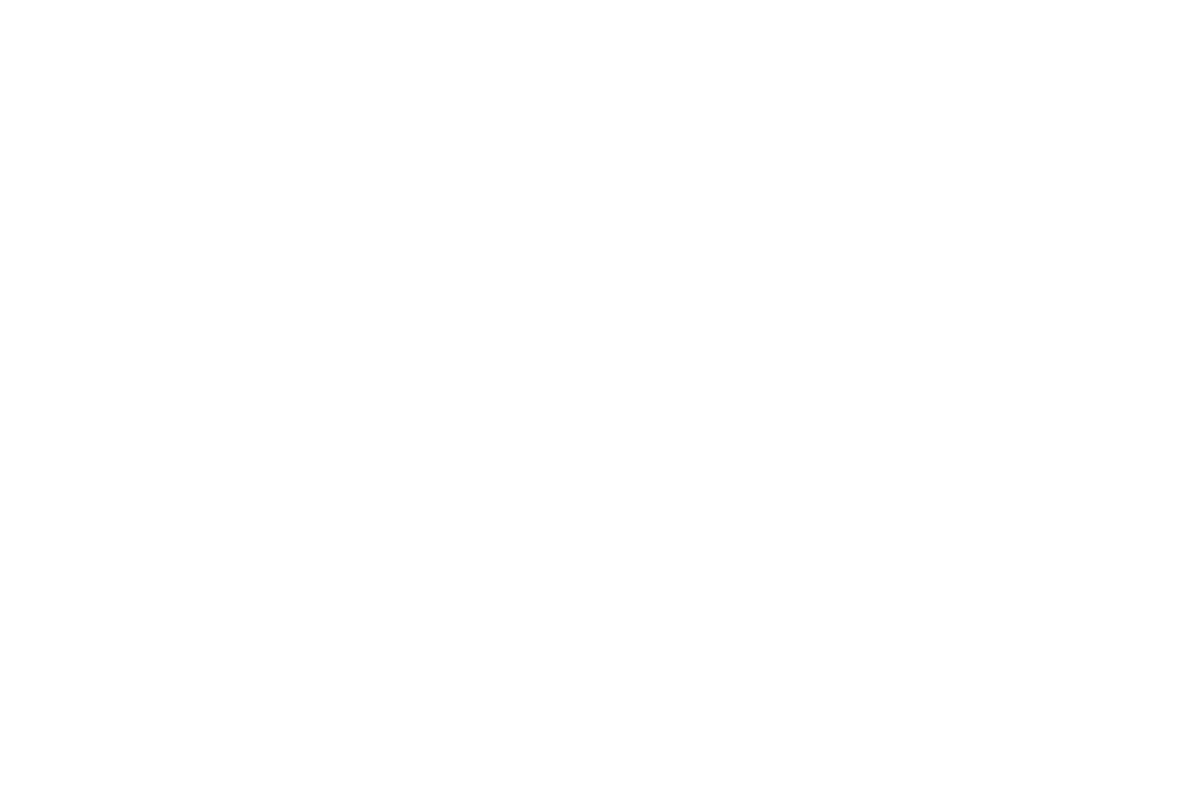

<IPython.core.display.Javascript object>


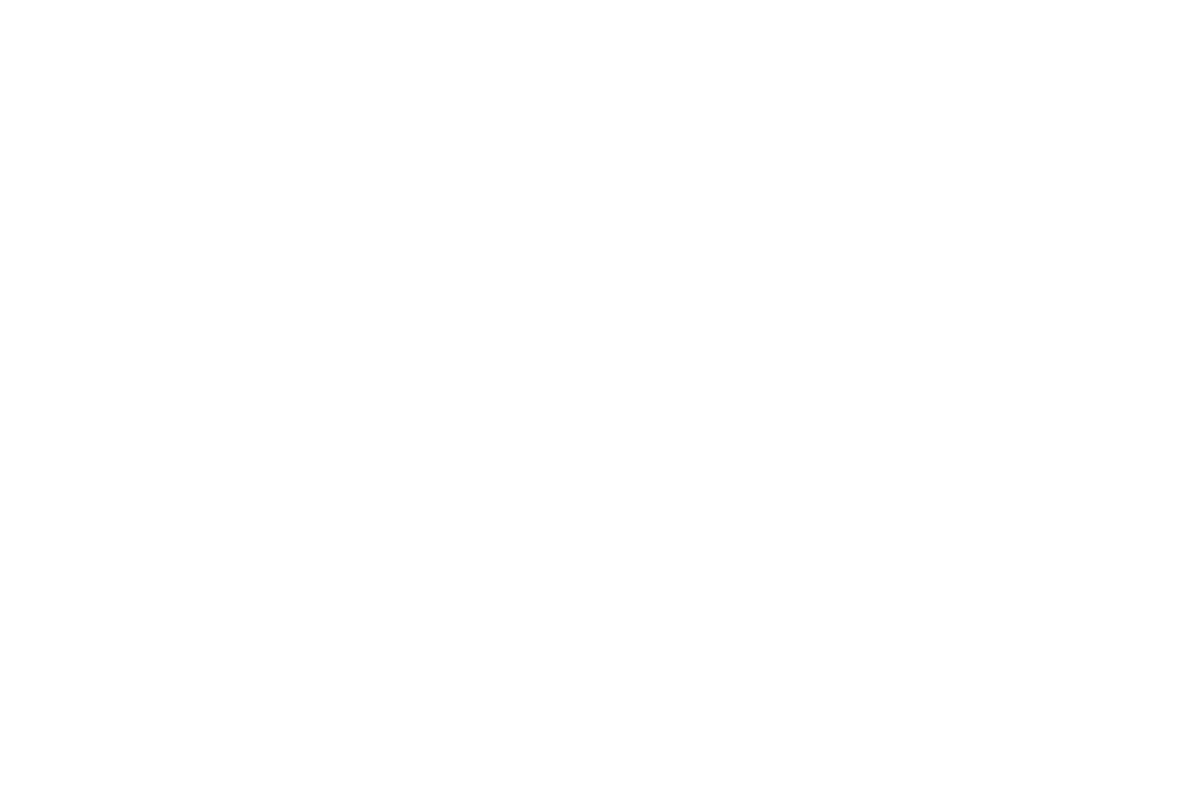

<IPython.core.display.Javascript object>


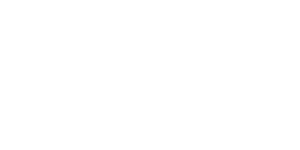

<IPython.core.display.Javascript object>


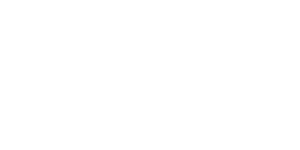

<IPython.core.display.Javascript object>


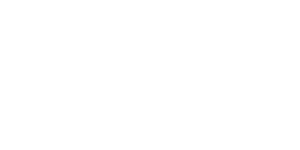

<IPython.core.display.Javascript object>


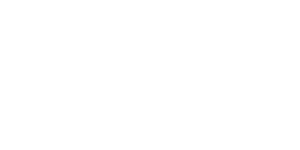

<IPython.core.display.Javascript object>


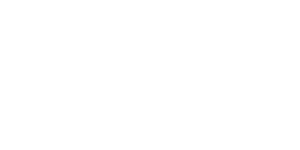

<IPython.core.display.Javascript object>


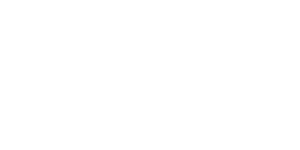

<IPython.core.display.Javascript object>


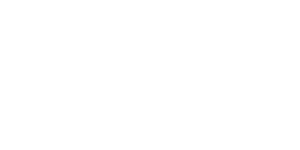

<IPython.core.display.Javascript object>


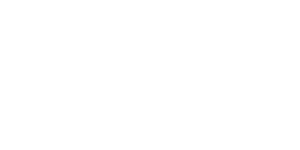

<IPython.core.display.Javascript object>


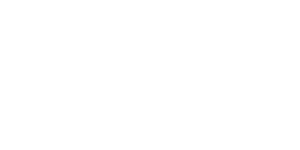

<IPython.core.display.Javascript object>


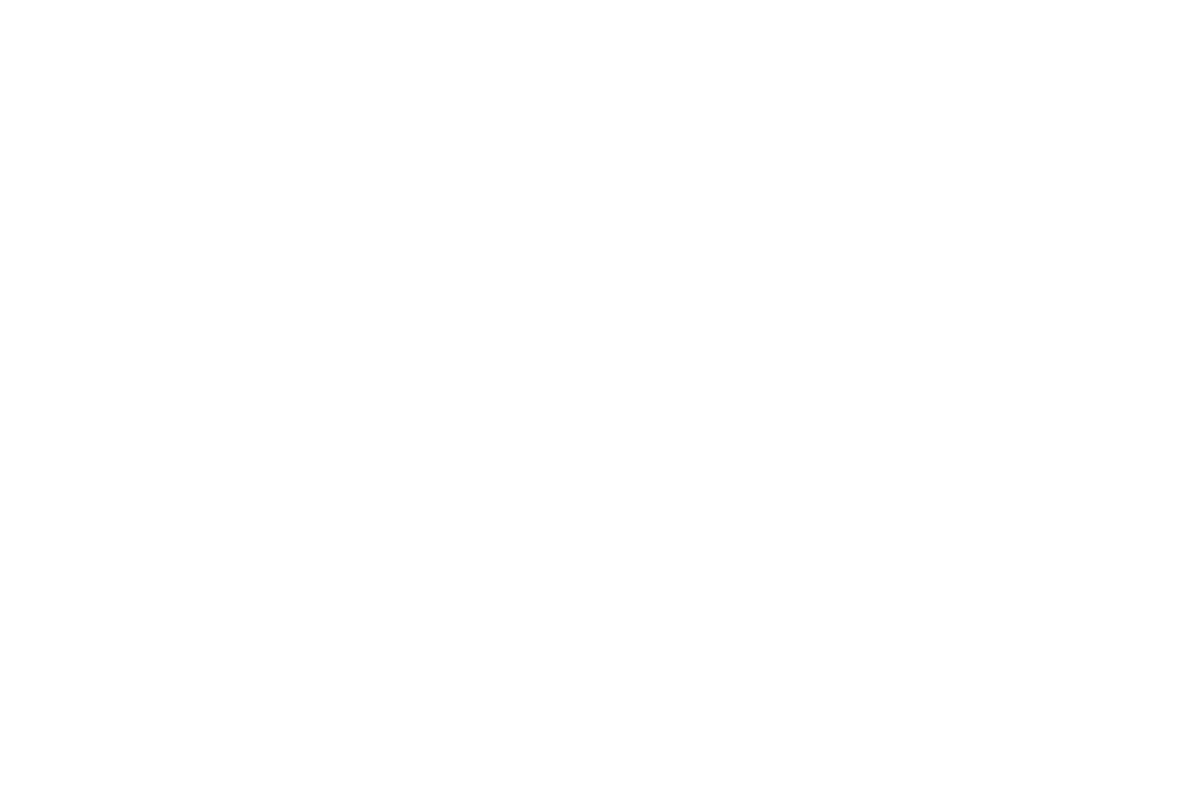

<IPython.core.display.Javascript object>


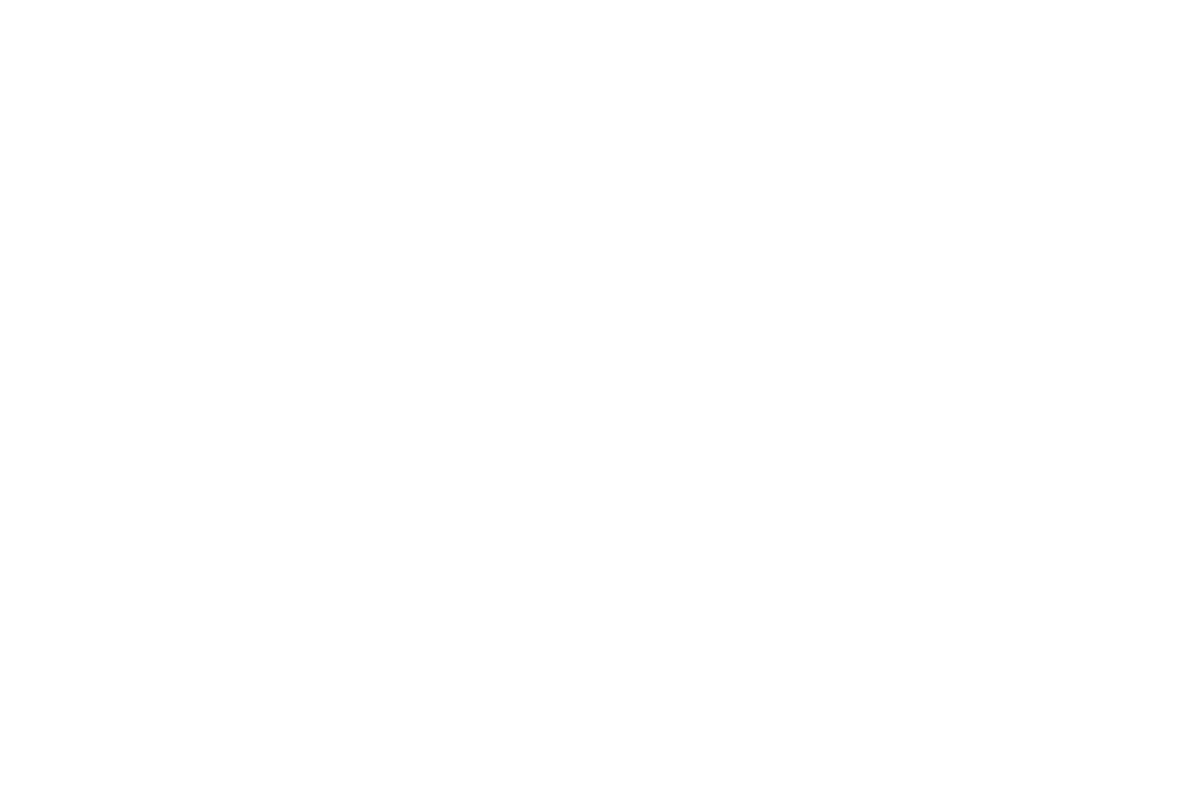

<IPython.core.display.Javascript object>


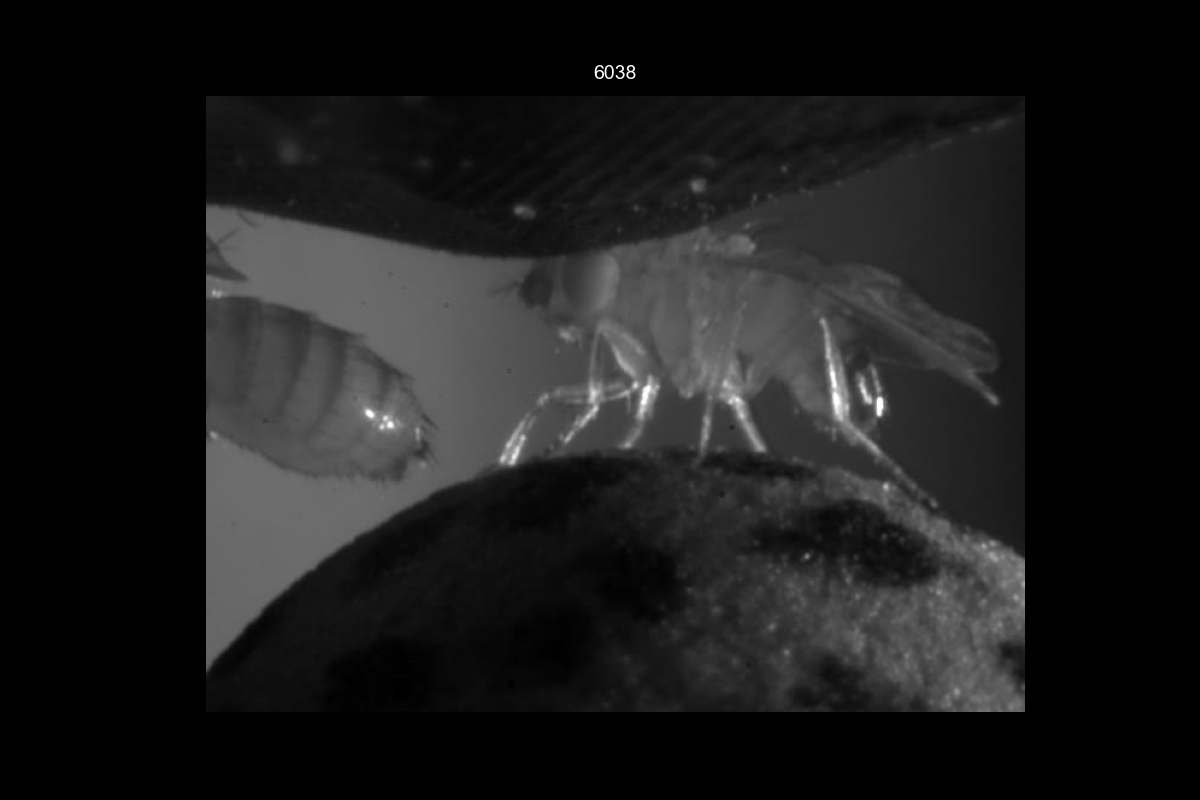

PermissionError: [Errno 13] Permission denied

In [113]:
# fig, axn = pl.subplots(10, 6, figsize=(9, 15))
# for ai, (ix, frame) in enumerate(zip(frame_ix, frames)):
#     ax=axn.flat[ai]
#     ax.imshow(frame)
#     ax.set_title(ix)
# pl.tight_layout()

for ai, (ix, frame) in enumerate(zip(frame_ix, frames)):
    fig, ax = pl.subplots()
    ax.imshow(frame)
    ax.set_title(ix)
    ax.axis('off')
    ax.set_aspect('equal')
    pl.savefig(os.path.join(figdir_tmp, '{}.png'.format(ix)))
    pl.close()

In [ ]:
mt_